In [4]:
## Import dependencies.
import os
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from mou_model import MOU

## Check whether simple_colors is installed, otherwise install using pip
try:
    from simple_colors import * # for printing colored and bold text
except:
    ! pip install simple_colors
## Check whether more_itertools is installed, otherwise install using pip
try:
    from more_itertools import unique_everseen # returns all varying values
except:
    !pip install more-itertools

## Import simple_colors
from simple_colors import *
## Import unique_everseen
from more_itertools import unique_everseen


%matplotlib inline
    
## Introduce flags
save_ts_flag = True
save_centered_ts_and_FC_flag = True
save_scaled_FC_flag = True
save_EC_and_model_parametes_flag = False
save_input_and_output_flag = True
plot_FC_scaled_avg_flag = True # If == False, FC_avg_scaled is plottet
investigate_BOLD_distribution_flag = True
investigate_scaled_BOLD_distribution_flag = True
investigate_FC_distribution_flag = True
investigate_FC_scaled_distribution_flag = True
investigate_rc_io_per_roi_flag = True
sample_groupsize= 'matched' # Valid options: 'matched', 'all subjects'
sample_groups_flag = True
# Flag 1
quick_optimize_flag = False
if quick_optimize_flag:
    epsilon_C = 0.001
else:
    epsilon_C = 0.0001
FC_scale = 'standard_scale' # Options: 'max_scale', 'standard_scale'
# Flag 2
io_based_on_nodal_degree_flag = False
# Flag 3
allow_all_connections_for_EC_flag = False
# Flag 4
optimize_with_FC_version = 'ts_scaled' # Options: 'FC_scaled','FC', 'ts_scaled'
# Flag 5
input_is_rowsum_flag = True # If == False, input = columnsum
# Flag 6
scale_ts_flag = True

## Introduce constants.
_RES_DIR = str(
    'flag1-' + str(int(quick_optimize_flag)) +
    ' flag2-' + str(int(io_based_on_nodal_degree_flag)) +
    ' flag3-' + str(int(allow_all_connections_for_EC_flag)) +
    ' flag4-' + str(optimize_with_FC_version) +
    ' flag5-' + str(int(input_is_rowsum_flag)) +
    ' flag6-' + str(int(scale_ts_flag)) + '/')
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0
seed = 0 # None

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    os.makedirs(_RES_DIR)
    print('created directory:', _RES_DIR)

In [5]:
## The following function was retrieved from 
# https://stackoverflow.com/questions/48970785/complex-matlab-struct-mat-file-read-by-python
# unchanged except from the prints, which were added to give the user a rough 
# idea of the data's structure.
def load_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects.
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
#                print(key)
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
#                print(key)
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function constructing nested dictionaries from matobjects
        """
#        print('\tcontaining another dictionary with the keys')
        d = {}
        for strg in matobj._fieldnames:
#            print('\t', strg)
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
#        print('\t\tcontaining an array\n\t\t\tof shape', ndarray.shape, 
#              '\n\t\t\tand dtype', ndarray.dtype)
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray
        
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
 #   print('The data in', filename, 'consists of', len(data.keys()) - 3,
 #         'element(s) with the following keys:\n')
    return _check_vars(data)

In [6]:
## Read in data and structure it.
# Read in SZ data.
fMRI_data = load_mat(
    'schizophrenics_data_and_data_description/cobre_schizo_aparc_ts')
keys_1st_layer = list(fMRI_data.keys())
data_per_subj = fMRI_data[keys_1st_layer[3]]
keys_2nd_layer = list(data_per_subj[0].keys())
#print('Subject with complete data, have the following keys:', str(keys_2nd_layer))
n_subjects = len(data_per_subj)
n_ts_samples, n_rois = data_per_subj[0]['timeseries'].shape 

## Chose only subjects for whom the full timeseries is present
timeseries = np.zeros([n_subjects, n_ts_samples, n_rois])
for i, i_subj in enumerate(data_per_subj):
    #print(i, '\t\t:', i_subj.keys())
    timeseries[i, :, :] = i_subj.get('timeseries')

## Exclude subjects who are marked for exclusion
subj_infos = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', header = 1)
mask_exclude_subj = subj_infos.loc[: , "Exlude?"]
mask_exclude_subj = mask_exclude_subj.replace("Motion",1)
mask_exclude_subj = mask_exclude_subj.replace("Disenrolled",1)
mask_exclude_subj = mask_exclude_subj.replace("Incomplete",1)
mask_exclude_subj = mask_exclude_subj.replace(np.nan,0)
mask_exclude_subj = mask_exclude_subj.to_numpy(dtype=bool)
ts_mixed = timeseries[~mask_exclude_subj]

## Separate healthy participants from schizophrenics
participant_type_labels = ["Control", "Patient"]
mask_patient_subj = subj_infos.loc[: , "Subject Type"]
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[0],0)
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[1],1)
mask_patient_subj = mask_patient_subj.to_numpy(dtype=bool)
mask_patient_subj = mask_patient_subj[~mask_exclude_subj]
ts_patients = ts_mixed[mask_patient_subj]
ts_patients = ts_patients[
    np.logical_not(np.isnan(ts_patients))].reshape((-1,150,68))
ts_controls = ts_mixed[~mask_patient_subj]
ts_controls = ts_controls[
    np.logical_not(np.isnan(ts_controls))].reshape((-1,150,68))
ts_patients = np.transpose(ts_patients, (0, 2, 1))
ts_controls = np.transpose(ts_controls, (0, 2, 1))
n_patients, n_rois_patients, n_ts_samples_patients = ts_patients.shape
n_controls, n_rois_controls, n_ts_samples_controls = ts_controls.shape
print('Participants with complete data:')
print('\t', n_patients, 'patient participants')
print('\t', n_controls, 'control participants')

# Read in ROI labels.
roi_labels_pd = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', 
    sheet_name='regions', usecols='C', header=1)
roi_labels_pd = roi_labels_pd.replace({'ctx-':''}, regex=True)
roi_labels_pd = roi_labels_pd.replace({' ':''}, regex=True)
roi_labels_pd = roi_labels_pd.replace({'-':'_'}, regex=True)
roi_labels = np.concatenate(roi_labels_pd.to_numpy())

parameter_dict = dict(roi_labels=roi_labels)

Participants with complete data:
	 60 patient participants
	 69 control participants


In [7]:
## Test timeserieswise for normal distribution
def test_ts_for_norm(group_ts):
    timeseries = group_ts.reshape([-1, group_ts.shape[2]])
    anderson_results = np.array([(stt.anderson(ts).statistic > stt.anderson(ts).critical_values[2]) for ts in timeseries], dtype=bool)
    print(np.array(np.where(anderson_results)).shape[1], 'of', timeseries.shape[0], 'timeseries.')

## Test each subject's data as a whole on normal distribution
#anderson2 = np.array([(stt.anderson(x).statistic > stt.anderson(x).critical_values[2]) for x in ts_patients.reshape(n_patients, -1)], dtype=bool)
#print(anderson2.shape)
#np.array(np.where(anderson2)).shape

test_ts_for_norm(ts_patients)
test_ts_for_norm(ts_controls)

878 of 4080 timeseries.
929 of 4692 timeseries.


Investigate distribution of BOLD timeseries values:


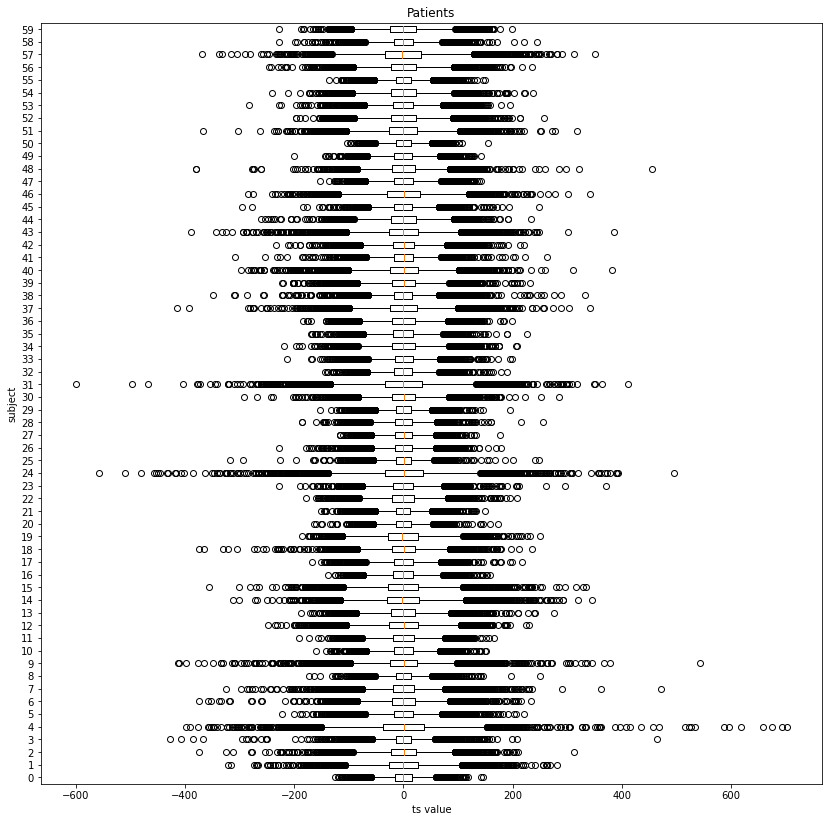

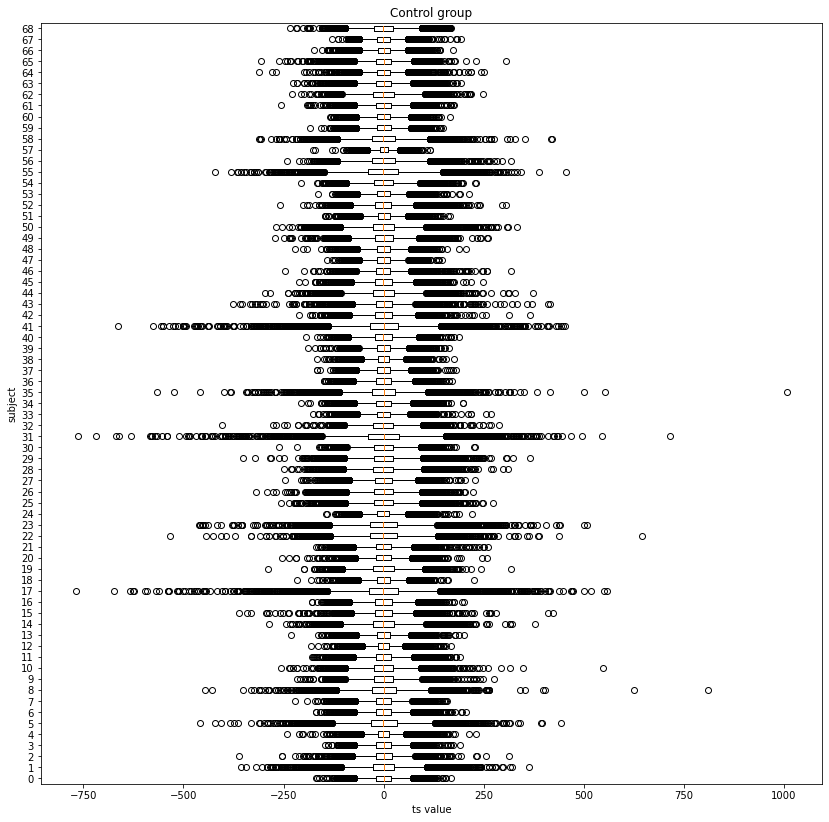

In [8]:
## Investigate distribution of BOLD timeseries values
def plot_ts_boxplot(BOLD_ts, group):
    plt.figure(figsize=(14, 14))
    plt.title(group)
    plt.ylabel('subject')
    plt.xlabel('ts value')
    n_subjects = BOLD_ts.shape[0]
    BOLD_ts = np.reshape(BOLD_ts, [n_subjects, -1])
    plt.boxplot(BOLD_ts.T, positions = np.arange(n_subjects), vert=False)
    plt.show()

if investigate_BOLD_distribution_flag:
    print(red('Investigate distribution of BOLD timeseries values:', 'bold'))
    plot_ts_boxplot(ts_patients, 'Patients')
    plot_ts_boxplot(ts_controls, 'Control group')

In [9]:
def standard_scale_BOLD_ts(BOLD_ts):
    """Standardize BOLD timeseries so that mean=0 and std=1 for all subjects.
    
    This function scales the BOLD timeseries according to z = (x - u) / s, 
    where x is the timeseries, u it's mean and s the standard diviation. The
    scaler scales each subject so that it's timeseries fullfills the 
    abovementioned requirements.
    """
    n_subjects = BOLD_ts.shape[0]
    standard_scaler = StandardScaler()
    BOLD_ts_scaled = standard_scaler.fit_transform(
        BOLD_ts.reshape(n_subjects, -1).T).T.reshape(BOLD_ts.shape)
    return BOLD_ts_scaled

Investigate distribution of scaled BOLD timeseries values:


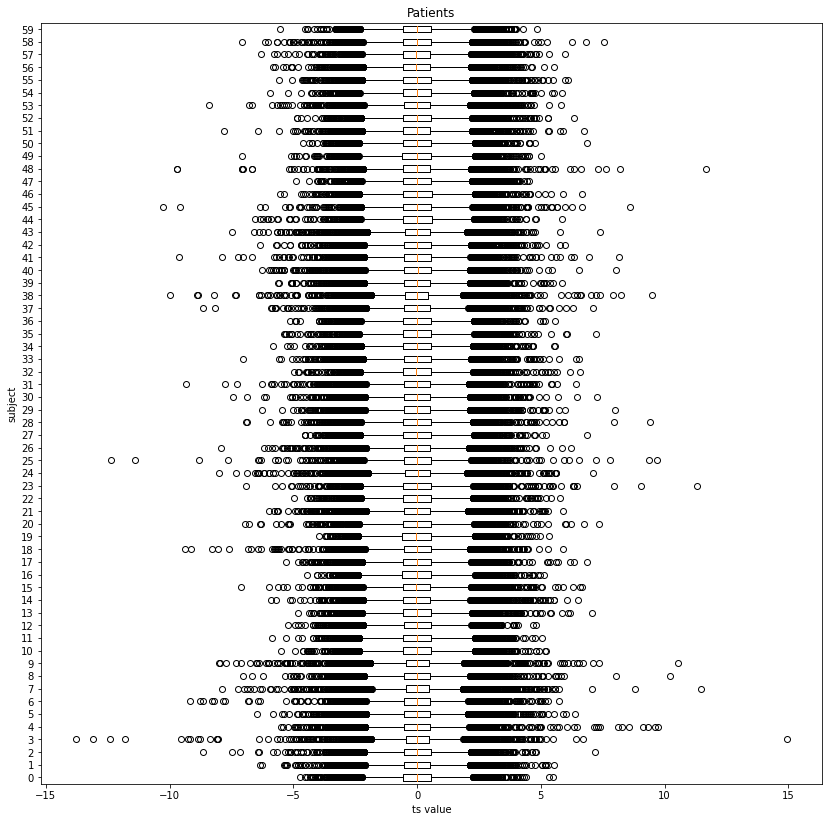

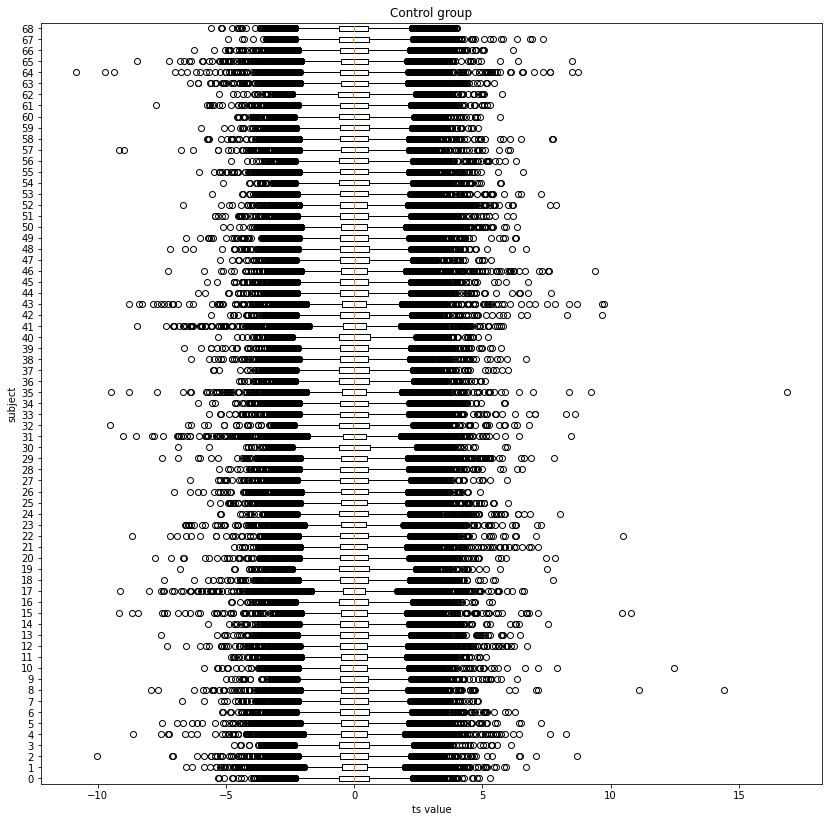

In [10]:
## Investigate distribution of scaled BOLD timeseries values
if scale_ts_flag:
    if investigate_scaled_BOLD_distribution_flag:
        print(red('Investigate distribution of scaled BOLD timeseries values:',
                  'bold'))
        ts_scaled_patients = standard_scale_BOLD_ts(ts_patients)
        ts_scaled_controls = standard_scale_BOLD_ts(ts_controls)
        plot_ts_boxplot(ts_scaled_patients, 'Patients')
        plot_ts_boxplot(ts_scaled_controls, 'Control group')

In [11]:
if save_ts_flag:
    # Save faultless timeseries sorted into patient & control group.
    np.save(_RES_DIR + 'ts_patients.npy', ts_patients)
    np.save(_RES_DIR + 'ts_controls.npy', ts_controls)
else:
    # Load faultless timeseries sorted into patients and control.
    ts_patients = np.load(_RES_DIR + 'ts_patients.npy')
    ts_controls = np.load(_RES_DIR + 'ts_controls.npy')

In [12]:
### Length of BOLD data is dependent on tau like in tau_lag_correlation.m.
## Calculate functional connectivity (BOLD covariances).
def calculate_FC_shift(filtered_ts_emp, n_shifts, **kwargs):
    n_subjects, n_rois, n_ts_samples = filtered_ts_emp.shape
    centered_ts = np.copy(filtered_ts_emp)
    FC_shift = np.zeros([n_subjects, n_rois, n_rois])
    FC_Reuters = np.zeros([n_subjects, n_rois, n_rois])
    n_ts_span = n_ts_samples - n_shifts
    for i_subject in range(n_subjects):
        # Center the time series (around zero).
        centered_ts[i_subject, :, :] -=  \
                np.outer(centered_ts[i_subject, :, :].
                         mean(axis=1), np.ones([n_ts_samples]))
        # Calculate covariances with one time shift.
        for i_roi in range(n_rois):
            FC_shift[i_subject, :, i_roi] = \
            np.dot(centered_ts[i_subject, :, :n_ts_span], 
                   centered_ts[i_subject, i_roi,
                               n_shifts:]) / float(n_ts_span)               
    return centered_ts, FC_shift

In [13]:
def calculate_FC_same_timeseries_length(filtered_ts, max_shift):
    """ This function calculates the FC represented by the BOLD covariances.
    The length of the timeseries is the same for all covariances and only 
    depends on the maximum shift 'max_shift'.
    """
    n_subjects, n_rois, n_ts_samples = filtered_ts.shape
    time_shifts = np.arange(max_shift + 1, dtype=int)
    n_shifts = len(time_shifts)
    centered_ts = np.copy(filtered_ts)
    FC = np.zeros([n_subjects, n_shifts, n_rois, n_rois])
    n_ts_span = n_ts_samples - n_shifts
    for i_subject in range(n_subjects):
        # Center the time series (around zero).
        centered_ts[i_subject, :, :] -=  \
                np.outer(centered_ts[i_subject, :, :].
                         mean(axis=1), np.ones([n_ts_samples]))
        # Calculate covariances with various time shifts.
        for i_shift in range(n_shifts):
            for i_roi in range(n_rois):
                FC[i_subject, i_shift, :, i_roi] = \
                (np.dot(centered_ts[i_subject, :,
                                       0:n_ts_span],
                       centered_ts[i_subject, i_roi,
                                       i_shift:n_ts_span + i_shift]) 
                 / float(n_ts_span))              
    return centered_ts, FC


if save_centered_ts_and_FC_flag:
    if scale_ts_flag:
        ts_p = ts_scaled_patients
        ts_c = ts_scaled_controls
    else:
        ts_p = ts_patients
        ts_c = ts_controls
    max_shift = 1
    centered_ts_patients, FC_patients = \
    calculate_FC_same_timeseries_length(ts_p, max_shift)
    centered_ts_controls, FC_controls = \
    calculate_FC_same_timeseries_length(ts_c, max_shift)

In [14]:
# ## Calculate functional connectivity FC (BOLD covariances).
# if not scale_ts_flag:
#     time_shifts = np.arange(4, dtype=int)
#     n_shifts = len(time_shifts)
#     if save_centered_ts_and_FC_flag:
#         ## Patient FC.
#         FC_patients = np.ndarray([n_patients, n_shifts, 
#                                   n_rois_patients, n_rois_patients])
#         for time_shift in time_shifts:
#             centered_ts_patients, FC_patients[:, time_shift, :, :] = \
#             calculate_FC_shift(ts_patients, time_shift)
# 
#         ## Control FC.
#         FC_controls = np.ndarray([n_controls, n_shifts, 
#                                   n_rois_controls, n_rois_controls])
#         for time_shift in time_shifts:
#             centered_ts_controls, FC_controls[:, time_shift, :, :] = \
#             calculate_FC_shift(ts_controls, time_shift)

In [15]:
# ## Calculate FC based on ts_scaled(BOLD covariances) [Q0 and Q1].
# if scale_ts_flag:
#     time_shifts = np.arange(4, dtype=int)
#     n_shifts = len(time_shifts)
#     if save_centered_ts_and_FC_flag:
#         ## Patient FC.
#         FC_patients = np.ndarray([n_patients, n_shifts, 
#                                   n_rois_patients, n_rois_patients])
#         for time_shift in time_shifts:
#             centered_ts_patients, FC_patients[:, time_shift, :, :] = \
#             calculate_FC_shift(ts_scaled_patients, time_shift)
# 
#         ## Control FC.
#         FC_controls = np.ndarray([n_controls, n_shifts, 
#                                   n_rois_controls, n_rois_controls])
#         for time_shift in time_shifts:
#             centered_ts_controls, FC_controls[:, time_shift, :, :] = \
#             calculate_FC_shift(ts_scaled_controls, time_shift)

In [16]:
if save_centered_ts_and_FC_flag:
    # Save faultless centered timeseries sorted into patient & control group.
    np.save(_RES_DIR + 'centered_ts_patients.npy', centered_ts_patients)
    np.save(_RES_DIR + 'centered_ts_controls.npy', centered_ts_controls)
    # Save raw FC.
    np.save(_RES_DIR + 'FC_patients.npy', FC_patients)
    np.save(_RES_DIR + 'FC_controls.npy', FC_controls)
else:
    # Load faultless centered timeseries sorted into patients and control.
    centered_ts_patients = np.load(_RES_DIR + 'centered_ts_patients.npy')
    centered_ts_controls = np.load(_RES_DIR + 'centered_ts_controls.npy')
    # Load raw FC.
    FC_patients = np.load(_RES_DIR + 'FC_patients.npy')
    FC_controls = np.load(_RES_DIR + 'FC_controls.npy')

In [17]:
## Test cell to show that the standardscaling does what it is supposed to do.
import statistics
## Use tested implementation from min_max_scaler
standard_scaler = StandardScaler()
FC0 = FC_patients[:, _I_NO_TIMESHIFT, :, :]
FC0_scaled = np.zeros([n_patients, n_rois, n_rois])
std = np.zeros([n_patients])

for i_subj in range(n_patients):
    FC0_scaled[i_subj, :, :] = standard_scaler.fit_transform(
        FC0[i_subj,:,:].reshape(-1, 1)).reshape(n_rois, n_rois)
    ## Standard scale per subject manually
    std[i_subj] = statistics.pstdev(FC0[i_subj,:,:].reshape(-1))
FC0_scaled_test2 = (FC0-FC0.mean(axis=1).mean(axis=1)[:, np.newaxis, np.newaxis])/std[:, np.newaxis,np.newaxis]
## Compare both versions (manually and with tested implementation)
#print(np.isclose(FC0_scaled, FC0_scaled_test2).all())

#print(standard_scaler.mean_, standard_scaler.scale_)
#import statistics
#print([FC0.mean(), statistics.pstdev(FC0.reshape(-1))])

## Compare result of final implementation with manually calculated results. 
standard_scaler = StandardScaler()
FC0_scaled_test = standard_scaler.fit_transform(
    FC0[:,:,:].reshape(n_patients, -1).T).T.reshape(FC0.shape)
FC_scaler = lambda matrix_3d: standard_scaler.transform(
    matrix_3d.reshape(n_patients, -1).T).T.reshape(matrix_3d.shape)
FC_emp = FC_scaler(FC_patients)
#print(standard_scaler.mean_.shape, standard_scaler.mean_)
#print(standard_scaler.scale_.shape, standard_scaler.scale_)

#print(np.isclose(FC0_scaled, FC0_scaled_test).all())
#print(np.isclose(FC_emp[:,0,:,:], FC0_scaled).all())
#print(np.isclose(FC_emp.mean(axis=2).mean(axis=2)[:,0], np.zeros([60,1])).all())

## Analyse distribution of FC values per subject to determine best 
# normalization or scaling option.
alpha = 0.05
#save_centered_ts_and_FC_flag = True
if save_centered_ts_and_FC_flag:
    conf_int_rc = np.array(stt.t.interval(
        1-alpha, FC0.shape[0]-1,
        loc=FC_patients.mean(axis=2).mean(axis=2),
        scale=stt.sem(FC_patients.reshape(n_patients, max_shift, -1), axis=2))).T
FC_scaled = FC_patients/FC_patients.mean(axis=2).mean(axis=2)[:, :, np.newaxis, np.newaxis]
#stt.sem(FC_scaled.reshape(n_patients, n_shifts, -1), axis=2)

In [18]:
def standard_scale(FC):
    """Standardize FC so that mean=0 and std=1 for FC0
    
    This function scales the FC according to z = (x - u) / s, where x is the
    unscaled FC, u it's mean and s the standard diviation. The scaler scales
    all the FC (for all time shifts) with the mean and standard diviation of
    FC0.
    """
    n_subjects = FC.shape[0]
    standard_scaler = StandardScaler()
    standard_scaler.fit(FC[:,_I_NO_TIMESHIFT,:,:].reshape(n_subjects, -1).T)
    FC_scaler = lambda matrix_3d: standard_scaler.transform(
        matrix_3d.reshape(n_subjects, -1).T).T.reshape(matrix_3d.shape)
    # The following commented version is equivalent to the uncommented version
    # below. Only here the scaler is applied, while it is not in the version 
    # below.
#    FC_scaled = (FC_scaler(FC)
#                 + standard_scaler.mean_[
#                     :, np.newaxis, np.newaxis, np.newaxis]
#                 / standard_scaler.scale_[
#                     :, np.newaxis, np.newaxis, np.newaxis])

    #FC_scaled = FC / standard_scaler.scale_[
    #    :, np.newaxis, np.newaxis, np.newaxis]
    
    FC_scaled = FC_scaler(FC) # results in Infs or NANs error in solve_lyapunov() (with epsilon_C=0.001 and with epsilon_C=0.0001)
    
    
    FC_scaled = FC_scaled / FC_scaled.max()
    
    
    #max(axis=1).max(axis=1)[:, np.newaxis, np.newaxis]
    #print(np.isclose(FC_scaled, FC_emp).all())
    return FC_scaled

In [19]:
def max_scale(FC):
    """Scale FC so that the max value of every subject's FC is 1.
    
    This function devides every subject's FC by it's maximal value.  
    """
    FC_scaled = FC/FC[:, _I_NO_TIMESHIFT,:, :].max(
        axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
    return FC_scaled

Due to the application of the min-max-scaler most of the FC values should be between 0 and 1
Min FC0 value: -0.1986429079987627
Mean FC0 value: 9.604005403331804e-20
Max FC0 value: 0.9999999999999999
Mean BOLD variance (diagonal of each FC0 matrix): 0.35646078299022455


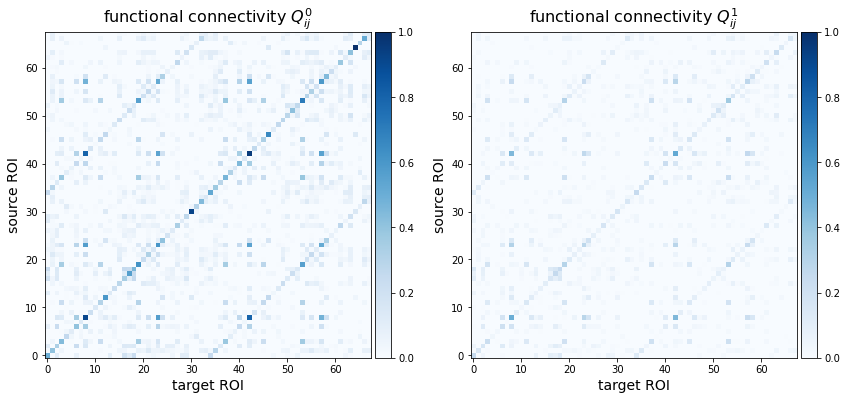

Due to the application of the min-max-scaler most of the FC values should be between 0 and 1
Min FC0 value: -0.14977837242321415
Mean FC0 value: -9.604005403331804e-20
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.27987464882927415


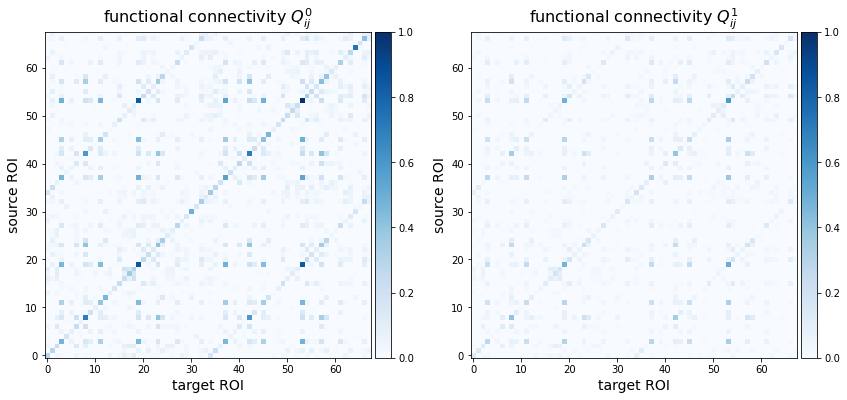

In [20]:
## Scale/normalize FC per subject by dividing by maximum FC value.
#save_centered_ts_and_FC_flag = True
if save_centered_ts_and_FC_flag:
    # Scale FC so that the max value of every subject's FC is 1.
    if FC_scale == 'max_scale':
        FC_scaled_patients = max_scale(FC_patients)
        # Visualize the effect of the scaling by printing the relevant values.
        #print('Maxima of FC_scaled_patients:\n\n',
        #      FC_scaled_patients.max(axis=2).max(axis=2
        FC_scaled_controls = max_scale(FC_controls)
        # Visualize the effect of the scaling by printing the relevant values.
        #print('Maxima of FC_scaled_controls:\n\n',
        #      FC_scaled_controls.max(axis=2).max(axis=2))
    elif FC_scale == 'standard_scale':
        FC_scaled_patients = standard_scale(FC_patients)
        FC_scaled_controls = standard_scale(FC_controls)
    
    ## Patients group.
    # Average FC over subjects.
    FC_avg_patients = FC_patients.mean(axis=_SUBJECT_AXIS)
    FC_scaled_avg_patients = FC_scaled_patients.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_avg_scaled_patients = FC_avg_patients/FC_avg_patients[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('\nMaxima of FC_avg_scaled_patients:\n\n',
    #      FC_avg_scaled_patients.max(axis=2).max(axis=2))

    if plot_FC_scaled_avg_flag:
        plotted_FC_version = FC_scaled_avg_patients
    else:
        plotted_FC_version = FC_avg_scaled_patients
        
    rescale_factor_for_plot = 1 / plotted_FC_version.max()
    plotted_FC_version *= rescale_factor_for_plot
    print('Due to the application of the min-max-scaler most of the FC values'
    ' should be between 0 and 1')
    print('Min FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
    print('Mean FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
    print('Max FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
    print('Mean BOLD variance (diagonal of each FC0 matrix):', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
              axis1=0, axis2=1).mean())
    # # Show distibution of FC0 values.
    # plt.figure()
    # plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
    #          bins=np.linspace(-1, 5, 30))
    # plt.xlabel('FC0 value', fontsize=14)
    # plt.ylabel('matrix element count', fontsize=14)
    # plt.title('distribution of FC0 values')

    # Show FC0 averaged over subjects.
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

    # Show FC1 averaged over subjects for.
    plt.subplot(122)
    FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
    plt.show()

    ## Control group.
    # Average FC over subjects.
    FC_avg_controls = FC_controls.mean(axis=_SUBJECT_AXIS)
    FC_scaled_avg_controls = FC_scaled_controls.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_avg_scaled_controls = FC_avg_controls/FC_avg_controls[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('\nMaxima of FC_avg_scaled_controls:\n\n',
    #      FC_avg_scaled_controls.max(axis=2).max(axis=2))

    if plot_FC_scaled_avg_flag:
        plotted_FC_version = FC_scaled_avg_controls
    else:
        plotted_FC_version = FC_avg_scaled_controls

    rescale_factor_for_plot = 1 / plotted_FC_version.max()
    plotted_FC_version *= rescale_factor_for_plot
    print('Due to the application of the min-max-scaler most of the FC values'
    ' should be between 0 and 1')
    print('Min FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
    print('Mean FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
    print('Max FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
    print('Mean BOLD variance (diagonal of each FC0 matrix):', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
              axis1=0, axis2=1).mean())
    #     # Show distibution of FC0 values.
    #     plt.figure()
    #     plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
    #              bins=np.linspace(-1, 5, 30))
    #     plt.xlabel('FC0 value', fontsize=14)
    #     plt.ylabel('matrix element count', fontsize=14)
    #     plt.title('distribution of FC0 values')

    # Show FC0 averaged over subjects.
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

    # Show FC1 averaged over subjects for.
    plt.subplot(122)
    FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
    plt.show()

In [21]:
if save_scaled_FC_flag:
    # Save scaled FC.
    np.save(_RES_DIR + 'FC_scaled_patients.npy', FC_scaled_patients)
    np.save(_RES_DIR + 'FC_scaled_controls.npy', FC_scaled_controls)
else:
    # Load scaled FC.
    FC_scaled_patients = np.load(_RES_DIR + 'FC_scaled_patients.npy')
    FC_scaled_controls = np.load(_RES_DIR + 'FC_scaled_controls.npy')

Investigate distribution of FC values:


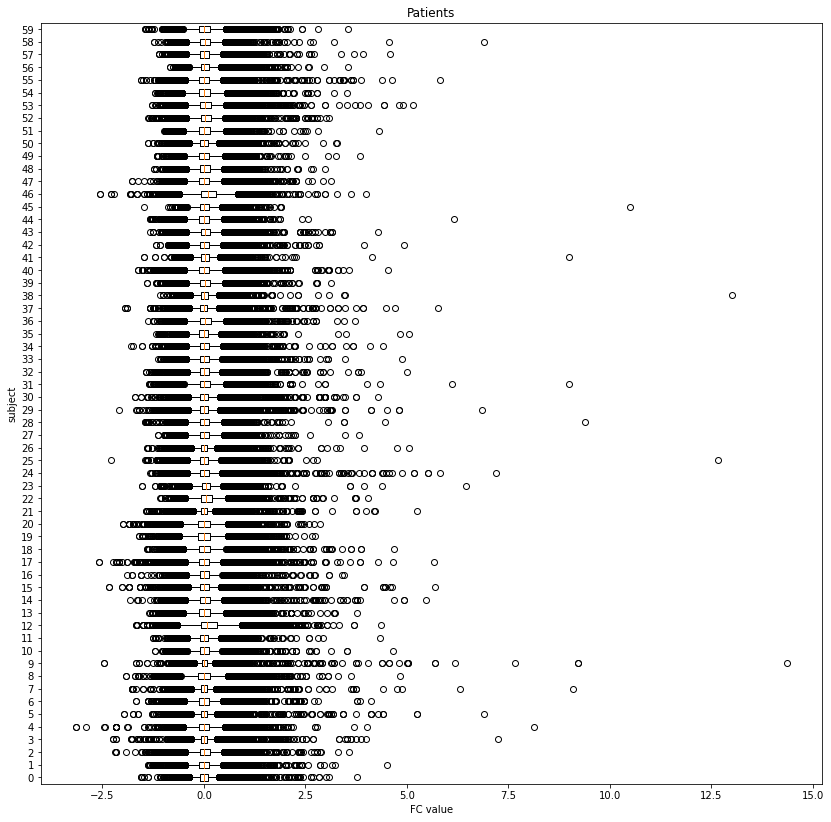

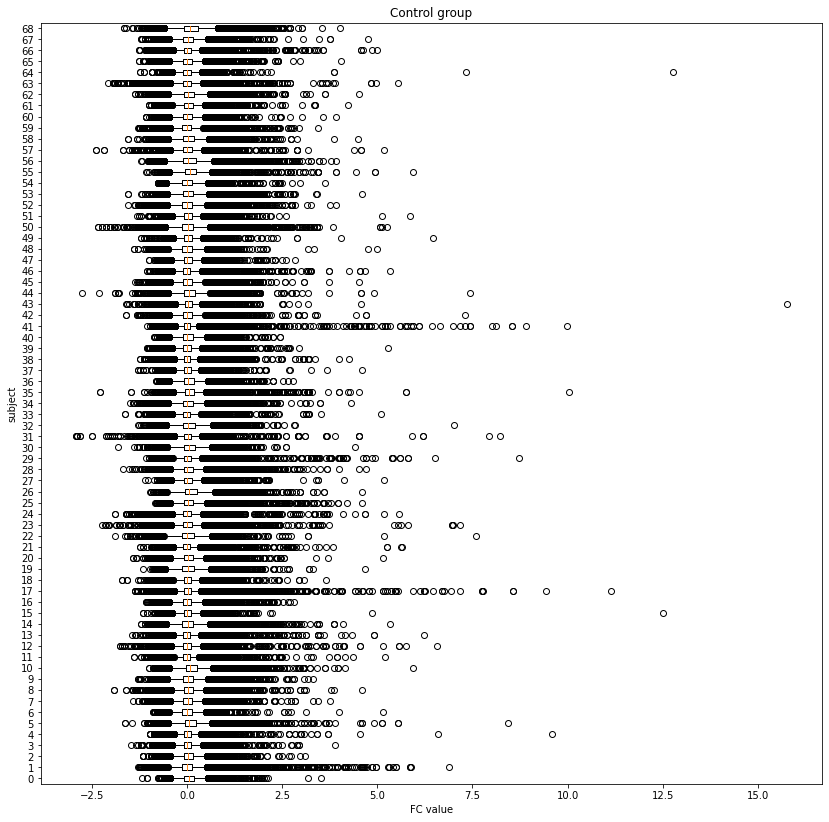

Investigate distribution of scaled FC values:


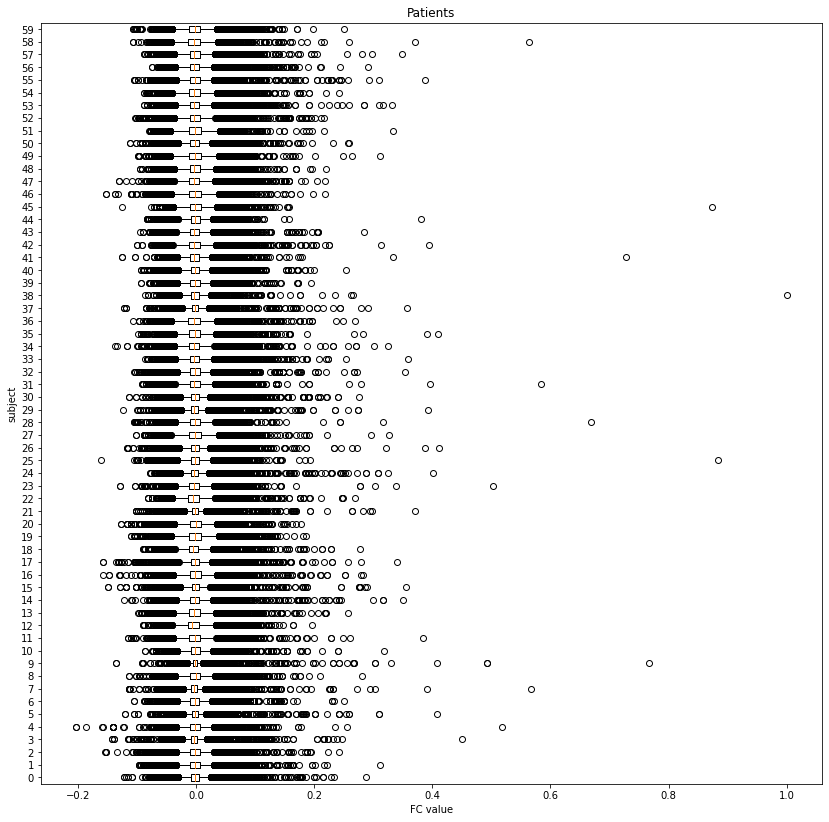

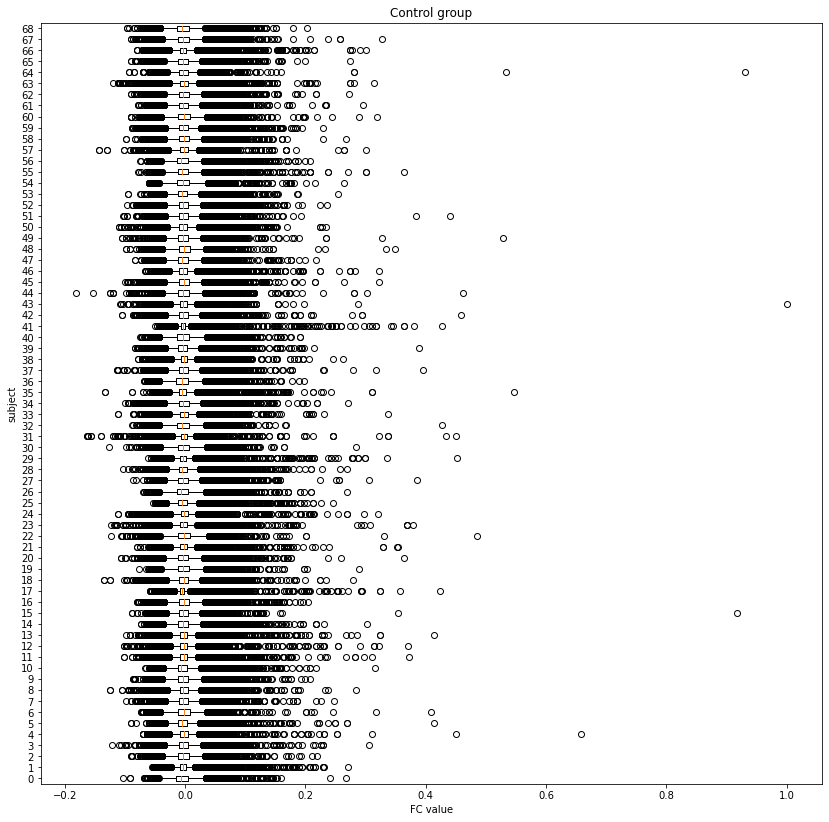

In [22]:
## Investigate distribution of FC values
def plot_FC_boxplot(FC, group):
    plt.figure(figsize=(14, 14))
    plt.title(group)
    plt.ylabel('subject')
    plt.xlabel('FC value')
    n_subjects = FC.shape[0]
    FC = np.reshape(FC, [n_subjects, -1])
    plt.boxplot(FC.T, positions = np.arange(n_subjects), vert=False)
    plt.show()

if investigate_FC_distribution_flag:
    print(red('Investigate distribution of FC values:', 'bold'))
    plot_FC_boxplot(FC_patients, 'Patients')
    plot_FC_boxplot(FC_controls, 'Control group')
if investigate_FC_scaled_distribution_flag:
    print(red('Investigate distribution of scaled FC values:', 'bold'))
    plot_FC_boxplot(FC_scaled_patients, 'Patients')
    plot_FC_boxplot(FC_scaled_controls, 'Control group')

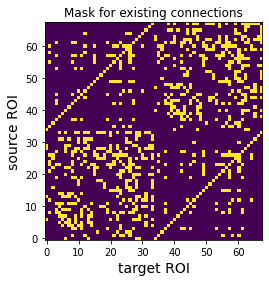

In [23]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hemispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
plotted_mask_EC = mask_EC

if allow_all_connections_for_EC_flag:
    mask_EC = None
    plotted_mask_EC = np.ones([n_rois, n_rois])
    
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(plotted_mask_EC, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()
# Add mask_EC to parameter_dict
parameter_dict['mask_EC'] = mask_EC

In [24]:
def calculate_EC(FC, mask_EC, **kwargs):
    """Calculate the EC per subject based on the BOLD timeseries.
    
    The matrixes FC0 and FC1 (covariances of BOLD signal without and with one
    time shift) are passed directly to fit_LO()@MOU for reasons explained in 
    the cell following this cell. In fit_LO()@MOU the EC (C matrix) and the 
    local variability (Sigma matrix) are calculated.
    """
    # Construct diagonal mask for input noise matrix
    # (here, no input cross-correlation).
    n_subjects, _, n_rois, _ = FC.shape

    # Run the model optimization.
    # Initialize the source arrays.
    # Jacobian (off-diagonal elements = EC)
    J_mod = np.zeros([n_subjects, n_rois, n_rois])
    # Local variance (input covariance matrix, chosen to be diagonal)
    Sigma_mod = np.zeros([n_subjects, n_rois, n_rois])
    # Model error
    dist_mod = np.zeros([n_subjects])
    # Approximation of variance about the fitted data (FC covariance matrices)
    R2_mod = np.zeros([n_subjects])
    # Between-region EC matrix
    C_mod = np.zeros([n_subjects, n_rois, n_rois])
    
    i_tau_opt = 1
    C = np.zeros([n_rois_patients, n_rois_patients])
    mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().
    mask_Sigma = np.eye(n_rois, dtype=bool)

    #print('NANs: ', np.isnan(FC).any(), '\tInfs: ', np.isinf(FC).any())
    for i_subject in range(n_subjects):
        #print('Max: ', FC[i_subject, :, :, :].max(), 'Min: ', FC[i_subject, :, :, :].min())
        # Run the estimation of model parameters, for all sessions.
        mou_model.fit_LO(FC[i_subject, :, :, :], i_tau_opt,
                         mask_Sigma=mask_Sigma, mask_C=mask_EC, **kwargs)
        # Organize the optimization results into arrays.
        # Extract Jacobian of the model.
        J_mod[i_subject, :, :] = mou_model.J
        # Extract noise (auto-)covariance matrix.
        Sigma_mod[i_subject, :, :] = mou_model.Sigma
        # Extract the matrix distance between the empirical objective
        # covariances and their model counterparts
        # (normalized for each objective matrix).
        dist_mod[i_subject] = mou_model.d_fit['distance']
        # The squared Pearson correlation is taken as an approximation
        # of the variance.
        R2_mod[i_subject] = mou_model.d_fit['correlation']**2
        # The between-region EC matrix of the model
        C_mod[i_subject, :, :] = mou_model.get_C()
        C_mod_dict = dict(C_mod = C_mod,
                          epsilon_C = epsilon_C)

        print('sub:', i_subject, ';\t model error, R2:',
              dist_mod[i_subject], R2_mod[i_subject])
    return [J_mod, Sigma_mod, dist_mod, R2_mod, C_mod_dict]

# Comments on function calculate_EC()

It is possible to directly pass the timeseries of the individual
subjects to fit()@MOU. In that case, however, the matrixes FC0 and FC1
(covariances of BOLD signal without and with one time shift)are calculated
in that function. They are not scaled in the original version by 
Andrea Insabato, Gorka Zamora-López and Matthieu Gilson and the method
solve_continuous_lyapunov() throws an error ('array must not contain infs
or NaNs'). As I want to keep the original version as unaltered as 
possible, the FC matrixes are calculated and scaled beforehand and passed
directly to the method fit_LO()@MOU.

Note that the calculation of the FC in fit()@MOU differs a bit from the 
calculation above (calculate_FC_shift). The length of the timeseries, 
for which the covariances are calculated all have the same length in 
fit()@MOU - as long as the maximum time shift allows. In the above 
version, on the other hand, the timeseries are chosen as long as possible
for each time shift individually.

In [25]:
## Calculate EC (based on FC_scaled) for each subject's EC.
if optimize_with_FC_version == 'FC_scaled':
    #epsilon_C = 0.00001
    #save_EC_and_model_parametes_flag = True
    if save_EC_and_model_parametes_flag:
        print(black('Calculate EC for patients:\n', 'bold'))
        [J_patients, Sigma_patients, dist_patients, R2_patients, 
         C_patients_dict] = calculate_EC(FC_scaled_patients, mask_EC, epsilon_C=epsilon_C)
        print('Finished!\n')
        print(black('Calculate EC for control group:\n', 'bold'))
        [J_controls, Sigma_controls, dist_controls, R2_controls, 
         C_controls_dict] = calculate_EC(FC_scaled_controls, mask_EC, epsilon_C=epsilon_C)
        print('Finished!\n')

In [26]:
## Calculate EC (based on FC with ts_scaled) for each subject's EC.
if optimize_with_FC_version == 'ts_scaled':
    epsilon_C = 0.0001
    #save_EC_and_model_parametes_flag = True
    if save_EC_and_model_parametes_flag:
        print(black('Calculate EC for patients:\n', 'bold'))
        [J_patients, Sigma_patients, dist_patients, R2_patients, 
         C_patients_dict] = calculate_EC(FC_patients, mask_EC, epsilon_C=epsilon_C, max_iter=10000)
        print('Finished!\n')
        print(black('Calculate EC for control group:\n', 'bold'))
        [J_controls, Sigma_controls, dist_controls, R2_controls, 
         C_controls_dict] = calculate_EC(FC_controls, mask_EC, epsilon_C=epsilon_C, max_iter=10000)
        print('Finished!\n')

In [27]:
np.save(_RES_DIR + 'parameter_dict.npy', parameter_dict)
if save_EC_and_model_parametes_flag:
    # Save EC per subject for patients & control group.
    np.save(_RES_DIR + 'C_patients_dict.npy', C_patients_dict)
    np.save(_RES_DIR + 'C_controls_dict.npy', C_controls_dict)
    savemat(_RES_DIR + 'C_patients_dict.mat',
            {'C_patients_dict': C_patients_dict})
    savemat(_RES_DIR + 'C_controls_dict.mat',
        {'C_controls_dict': C_controls_dict})
    # Save model parametes.
    np.save(_RES_DIR + 'J_patients.npy', J_patients)
    np.save(_RES_DIR + 'J_controls.npy', J_controls)
    np.save(_RES_DIR + 'Sigma_patients.npy', Sigma_patients)
    np.save(_RES_DIR + 'Sigma_controls.npy', Sigma_controls)
    np.save(_RES_DIR + 'dist_patients.npy', dist_patients)
    np.save(_RES_DIR + 'dist_controls.npy', dist_controls)
    np.save(_RES_DIR + 'R2_patients.npy', R2_patients)
    np.save(_RES_DIR + 'R2_controls.npy', R2_controls)
else:
    # Load EC per subject for patients & control group.
    C_patients_dict = np.load(_RES_DIR + 'C_patients_dict.npy', allow_pickle=True).tolist()
    C_controls_dict = np.load(_RES_DIR + 'C_controls_dict.npy', allow_pickle=True).tolist()
    # Load model parametes.
    J_patients = np.load(_RES_DIR + 'J_patients.npy')
    J_controls = np.load(_RES_DIR + 'J_controls.npy')
    Sigma_patients = np.load(_RES_DIR + 'Sigma_patients.npy')
    Sigma_controls = np.load(_RES_DIR + 'Sigma_controls.npy')
    dist_patients = np.load(_RES_DIR + 'dist_patients.npy')
    dist_controls = np.load(_RES_DIR + 'dist_controls.npy')
    R2_patients = np.load(_RES_DIR + 'R2_patients.npy')
    R2_controls = np.load(_RES_DIR + 'R2_controls.npy')
C_patients = C_patients_dict['C_mod']
C_controls = C_controls_dict['C_mod']
print('Save flag is', green(save_EC_and_model_parametes_flag, 'bold'))
print('epsilon_C =', C_patients_dict['epsilon_C'])

Save flag is False
epsilon_C = 0.0001


In [28]:
## Examine input and output to and from the RC.
def calculate_feeder_input_and_output(C, input_is_rowsum=input_is_rowsum_flag):
    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    # Create a 2D-mask for inter rich club connections.
    mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
    rc_ind_combin = np.array(list(
        itertools.product(indexes_rc, repeat=2))).T
    mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

    no_rc_connections_C = np.copy(C)
    no_rc_connections_C[mask_inter_rc] = 0
    if io_based_on_nodal_degree_flag:
        input_rc = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                                axis=input_axis, keepdims=True))
        output_rc = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                                 axis=output_axis, keepdims=True))
    else:
        input_rc = no_rc_connections_C[:, :].sum(axis=input_axis)
        output_rc = no_rc_connections_C[:, :].sum(axis=output_axis)

#    io_ratio_rc = input_rc[mask_rc] / output_rc[mask_rc]
#    # Calculate and print the mean io-ratio and the CI for rich club regions
#    io_ratio_rc_mean = io_ratio_rc[:].mean()
#    io_ratio_rc_conf_int = np.array(stt.t.interval(
#        0.95, io_ratio_rc.shape[0]-1, loc=io_ratio_rc_mean,
#        scale=stt.sem(io_ratio_rc)))
#    print('Mean input-to-output ratio of the rich club:\n',
#          str(io_ratio_rc_mean))
#    print('95% confidence interval (rich club):\n', str(io_ratio_rc_conf_int))
#    rc_ratio_of_total_io = (roi_input[mask_rc].sum()
#                            / roi_output[mask_rc].sum())
#    print('Total input to total output ratio between RC and periphery:\n',
#          str(rc_ratio_of_total_io))

    # Create a 2D-mask for inter periphery connections.
    mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
    periph_ind_combin = np.array(list(itertools.product(list(
        x for x in range(68) if x not in indexes_rc), repeat=2))).T
    mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
    # Calculate the ratio of incoming/outgoing EC among peripheral regions
    inter_periph_C = np.copy(C)
    inter_periph_C[~mask_inter_periph] = 0
    if io_based_on_nodal_degree_flag:
        input_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=input_axis, keepdims=True))
        output_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=output_axis, keepdims=True))
    else:
        input_periph = inter_periph_C[:, :].sum(axis=input_axis)
        output_periph = inter_periph_C[:, :].sum(axis=output_axis)

#    io_ratio_periph = (input_periph[~mask_rc] / output_periph[~mask_rc])
#    # Calculate and print the mean io-ratio and the CI for peripheral regions
#    io_ratio_periph_mean = io_ratio_periph.mean()
#    io_ratio_periph_conf_int = np.array(stt.t.interval(
#        0.95, io_ratio_periph.shape[0]-1, loc=io_ratio_periph_mean,
#        scale=stt.sem(io_ratio_periph)))
#    print('Mean input-to-output ratio of the priphery:\n',
#          str(io_ratio_periph_mean))
#    print('95% confidence interval (periphery):\n',
#          str(io_ratio_periph_conf_int))
#    periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
#                                / roi_output[~mask_rc].sum())
#    print('Total input to total output ratio of the priphery:\n',
#          str(periph_ratio_of_total_io))
    return input_rc, output_rc, input_periph, output_periph



# Define RC
rc_labels = ['precuneus', 'superiorfrontal', 'superiorparietal']
mask_rc = np.zeros(n_rois, dtype=bool)
for i_rc_label in rc_labels:
    mask_rc[np.frompyfunc(lambda x: i_rc_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_rc = np.array(*np.where(mask_rc))
print(black('Rich club regions:\n', 'bold'), roi_labels[mask_rc].tolist())

#[roi_input, roi_output, io_ratio_rc,
# io_ratio_periph] = calculate_feeder_input_and_output(C)
#[roi_input_controls, roi_output_controls, io_ratio_rc_controls,
# io_ratio_periph_controls] = calculate_feeder_input_and_output(C_controls)

#print(black('\nPatient group:', 'bold'))
[input_rc_patients, output_rc_patients, input_periph_patients,
output_periph_patients] = np.squeeze(np.split(
    np.array([ calculate_feeder_input_and_output(x) for x in C_patients ]),
    4, axis=1))
#print(black('\nControl group:', 'bold'))
[input_rc_controls, output_rc_controls, input_periph_controls,
output_periph_controls] = np.squeeze(np.split(
    np.array([ calculate_feeder_input_and_output(x) for x in C_controls ]),
    4, axis=1))

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']


In [29]:
if save_input_and_output_flag:
    # Save input & output to and from RC.
    np.save(_RES_DIR + 'input_rc_patients.npy', input_rc_patients)
    np.save(_RES_DIR + 'output_rc_patients.npy', output_rc_patients)
    np.save(_RES_DIR + 'input_rc_controls.npy', input_rc_controls)
    np.save(_RES_DIR + 'output_rc_controls.npy', output_rc_controls)
    # Save inter-periphery input & output.
    np.save(_RES_DIR + 'input_periph_patients.npy', input_periph_patients)
    np.save(_RES_DIR + 'output_periph_patients.npy', output_periph_patients)
    np.save(_RES_DIR + 'input_periph_controls.npy', input_periph_controls)
    np.save(_RES_DIR + 'output_periph_controls.npy', output_periph_controls)
else:
    # Load input & output to and from RC.
    input_rc_patients = np.load(_RES_DIR + 'input_rc_patients.npy')
    output_rc_patients = np.load(_RES_DIR + 'output_rc_patients.npy')
    input_rc_controls = np.load(_RES_DIR + 'input_rc_controls.npy')
    output_rc_controls = np.load(_RES_DIR + 'output_rc_controls.npy')
    # Save inter-periphery input & output.#
    input_periph_patients = np.load(_RES_DIR + 'input_periph_patients.npy')
    output_periph_patients = np.load(_RES_DIR + 'output_periph_patients.npy')
    input_periph_controls = np.load(_RES_DIR + 'input_periph_controls.npy')
    output_periph_controls = np.load(_RES_DIR + 'output_periph_controls.npy')

RC-indexes:
 [23 26 27 57 60 61]
Investigate input and output regionwise for RC-periphery (feeder) connections:


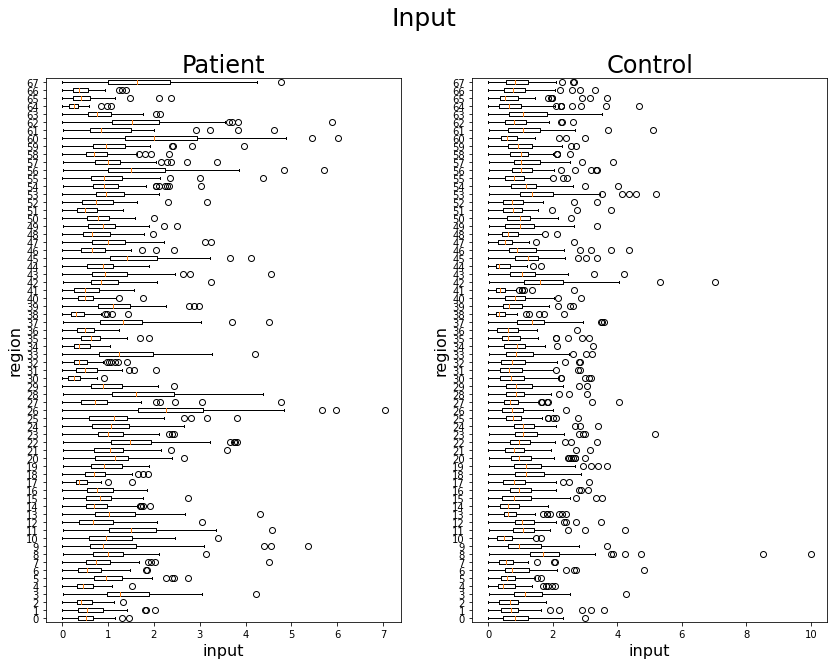

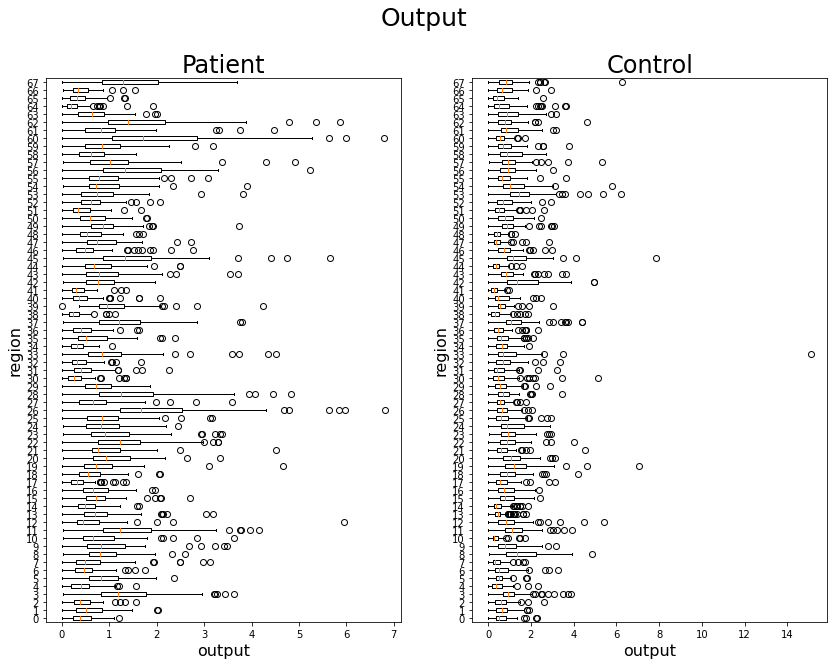

Mean rc input:	 0.9747425485616573 (patients)	 0.8573766144822583 (contols)


In [30]:
## Investigate input and output regionwise for RC-periphery connections.
def plot_feeder_io_boxplot(input_rc, output_rc, group):
    plt.figure(figsize=(14, 10))
    plt.suptitle(group, fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    plt.subplot(121)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    n_rois = input_rc.shape[1]
    plt.boxplot(input_rc, positions = np.arange(n_rois), vert=False)
    plt.subplot(122)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    n_rois = output_rc.shape[1]
    plt.boxplot(output_rc, positions = np.arange(n_rois), vert=False)
    plt.show()
    
def plot_feeder_io_group_comparing_boxplot(input_patients, output_patients,
                              input_controls, output_controls):
    plt.figure(figsize=(14, 10))
    plt.suptitle('Input', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    plt.subplot(121)
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    n_rois = input_patients.shape[1]
    plt.boxplot(input_patients, positions = np.arange(n_rois), vert=False)
    plt.subplot(122)
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    n_rois = input_controls.shape[1]
    plt.boxplot(input_controls, positions = np.arange(n_rois), vert=False)
    plt.show()
    plt.figure(figsize=(14, 10))
    plt.suptitle('Output', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    plt.subplot(121)
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    n_rois = output_patients.shape[1]
    plt.boxplot(output_patients, positions = np.arange(n_rois), vert=False)
    plt.subplot(122)
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    n_rois = output_controls.shape[1]
    plt.boxplot(output_controls, positions = np.arange(n_rois), vert=False)
    plt.show()
    
if investigate_rc_io_per_roi_flag:
    suptitle_fontsize = 25
    title_fontsize = 24
    axis_lable_fontsize = 16
    fontsize = 15
    top_adjust = 0.88
    print(black('RC-indexes:\n', 'bold'), indexes_rc)
    print(red('Investigate input and output regionwise for RC-periphery'
              ' (feeder) connections:', 'bold'))
    #plot_feeder_io_boxplot(input_rc_patients, output_rc_patients, 'Patients')
    #plot_feeder_io_boxplot(input_rc_controls, output_rc_controls, 'Controls')
    plot_feeder_io_group_comparing_boxplot(
        input_rc_patients,input_rc_controls,
        output_rc_patients, output_rc_controls)
    print('Mean rc input:\t', input_rc_patients.mean(),
      '(patients)\t', input_rc_controls.mean(), '(contols)')

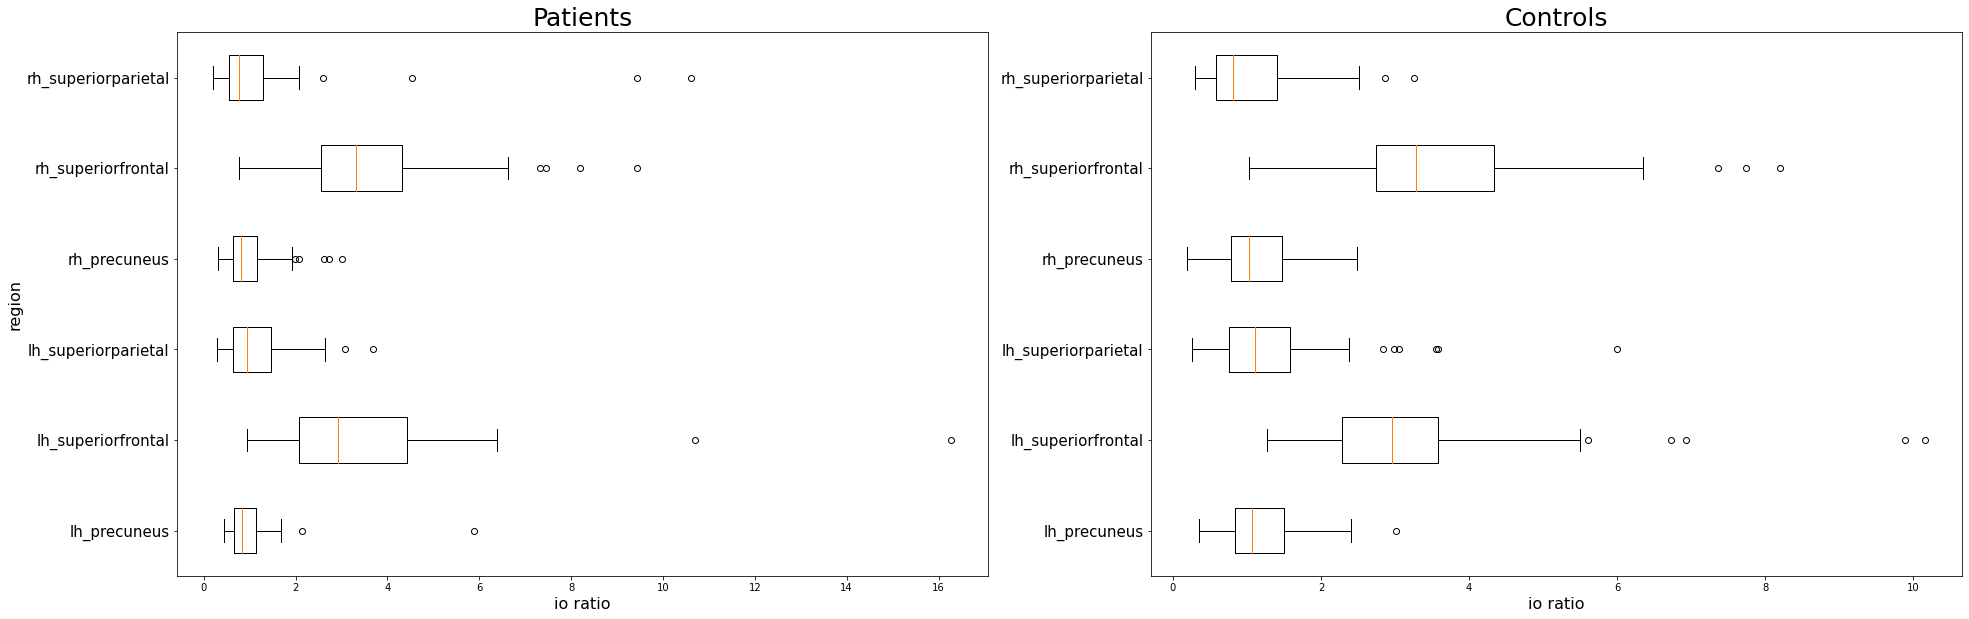

Mean rc io ratio:	 1.934100886151782 (patients)	 1.9311585253204746 (contols)


In [31]:
## Examine io ratio of RC regions.
def plot_rc_io_ratio(io_ratio_rc_patients, io_ratio_rc_controls,
                     mask_rc=mask_rc):
    plt.figure(figsize=(32, 10))
    plt.subplot(121)
    plt.title('Patients', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    n_rois = io_ratio_rc_patients.shape[1]
    plt.boxplot(io_ratio_rc_patients, positions = np.arange(n_rois),
                vert=False)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.yticks(np.arange(n_rois), roi_labels[mask_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.subplot(122)
    plt.title('Controls', fontsize=suptitle_fontsize)
    n_rois = io_ratio_rc_controls.shape[1]
    plt.boxplot(io_ratio_rc_controls, positions = np.arange(n_rois),
                vert=False)
    plt.yticks(np.arange(n_rois), roi_labels[mask_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.show()
    
#    # Calculate and print the mean io-ratio and the CI for rich club regions
#    io_ratio_rc_mean = io_ratio_rc[:].mean()
#    io_ratio_rc_conf_int = np.array(stt.t.interval(
#        0.95, io_ratio_rc.shape[0]-1, loc=io_ratio_rc_mean,
#        scale=stt.sem(io_ratio_rc)))
#    print('Mean input-to-output ratio of the rich club:\n',
#          str(io_ratio_rc_mean))
#    print('95% confidence interval (rich club):\n', str(io_ratio_rc_conf_int))
#    rc_ratio_of_total_io = (roi_input[mask_rc].sum()
#                            / roi_output[mask_rc].sum())
#    print('Total input to total output ratio between RC and periphery:\n',
#          str(rc_ratio_of_total_io))
io_ratio_rc_patients = (input_rc_patients[:, mask_rc]
                        / output_rc_patients[:, mask_rc])
io_ratio_rc_controls = (input_rc_controls[:, mask_rc]
                        / output_rc_controls[:, mask_rc])
plot_rc_io_ratio(io_ratio_rc_patients, io_ratio_rc_controls)

io_ratio_rc_mean_patients = io_ratio_rc_patients.mean()
io_ratio_rc_mean_controls = io_ratio_rc_controls.mean()
print('Mean rc io ratio:\t', io_ratio_rc_mean_patients,
      '(patients)\t', io_ratio_rc_mean_controls, '(contols)')

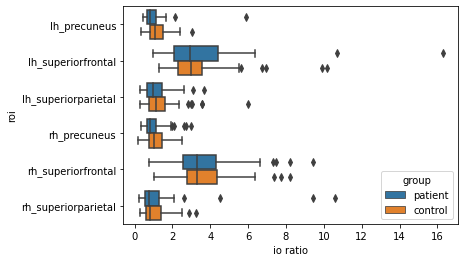

The patient`s variance is greater than the control`s for 5 of 6 rc regions.


In [32]:
## Compare groups in one boxplot with respect to io ratio of rc regions. 
dataframe_patients = pd.DataFrame(io_ratio_rc_patients.reshape(-1),
                                  columns=['io ratio'])
dataframe_patients['group'] = np.repeat('patient', dataframe_patients.size)
dataframe_patients['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_patients, 1).reshape(-1)

dataframe_controls = pd.DataFrame(io_ratio_rc_controls.reshape(-1),
                                  columns=['io ratio'])
dataframe_controls['group'] = np.repeat('control', dataframe_controls.size)
dataframe_controls['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_controls, 1).reshape(-1)

dataframe_all_subjects = dataframe_patients.append(dataframe_controls)

ax = sns.boxplot(x = dataframe_all_subjects['io ratio'], 
            y = dataframe_all_subjects['roi'], 
            hue = dataframe_all_subjects['group'])
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":16})
#ax.set_title("Title",fontsize=24)
plt.show()
roi_count_patients_greater_than_controls = sum(
    np.var(io_ratio_rc_patients, axis=0) > np.var(io_ratio_rc_controls, axis=0))
print('The patient`s variance is greater than the control`s for', 
      roi_count_patients_greater_than_controls, 'of', 
      len(indexes_rc), 'rc regions.')

In [33]:
## Patients: Analyse rc input with regard to max values. 
n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_patients = Counter()
input_Counter_rois_total_patients = Counter()
output_Counter_subjects_total_patients = Counter()
output_Counter_rois_total_patients = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_rc_patients.T == np.outer(np.sort(
        input_rc_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_patients += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_rc_patients == np.outer(np.sort(
        input_rc_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_patients += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_rc_patients.T == np.outer(np.sort(
        output_rc_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_patients += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_rc_patients == np.outer(np.sort(
        output_rc_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_patients += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_patients.T == np.outer(np.sort(
        io_ratio_rc_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))
    

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64), array([12, 21, 58, 46, 41, 37, 41, 46,  5,  3, 23,  5, 50, 21, 21, 12, 11,
       41, 21,  3, 21,  5, 41, 31,  5,  5, 41, 41, 51, 12, 50, 21, 12,  3,
       23, 12, 28, 41, 51, 41, 12, 46, 46, 51, 37,  7, 29, 46, 21, 12, 51,
       51, 41,  5, 12,  5,  5, 12, 35, 41, 21, 46, 41, 21,  0, 46, 12,  5],
      dtype=int64))
Counter({41: 11, 12: 10, 21: 9, 5: 9, 46: 7, 51: 5, 3: 3, 37: 2, 23: 2, 50: 2, 58: 1, 11: 1, 31: 1, 28: 1, 7: 1, 29: 1, 35: 1, 0: 1})
[0, 3, 5, 7, 11, 12, 21, 23, 28, 29, 31, 35, 37, 41, 46, 50, 51, 58]
	 2. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8

In [34]:
## Controls: Analyse rc input with regard to max values. 
n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_controls = Counter()
input_Counter_rois_total_controls = Counter()
output_Counter_subjects_total_controls = Counter()
output_Counter_rois_total_controls = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_rc_controls.T == np.outer(np.sort(
        input_rc_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_controls += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_rc_controls == np.outer(np.sort(
        input_rc_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_controls += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_rc_controls.T == np.outer(np.sort(
        output_rc_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_controls += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_rc_controls == np.outer(np.sort(
        output_rc_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_controls += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_controls.T == np.outer(np.sort(
        io_ratio_rc_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64), array([48, 48,  8, 64, 46, 57,  8, 46, 38, 46, 46, 57,  5, 46,  8,  8,  8,
       64, 19, 38, 57, 33,  8,  5,  8,  4, 64,  7, 57, 46, 64, 64,  8, 57,
       46, 57, 57,  5,  7, 46,  5, 48, 64,  8, 57,  8,  5, 46,  5, 33, 57,
       46, 46,  5, 46, 21, 46,  8,  8, 64, 57, 57, 57, 47,  8,  7,  5, 46],
      dtype=int64))
Counter({46: 14, 8: 13, 57: 12, 5: 8, 64: 7, 48: 3, 7: 3, 38: 2, 33: 2, 19: 1, 4: 1, 21: 1, 47: 1})
[4, 5, 7, 8, 19, 21, 33, 38, 46, 47, 48, 57, 64]
	 2. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 2

In [35]:
## Compare patients and controls with respect to the maximum io values.
print(indexes_rc)
print(black('Patients:', 'bold'))
print('\ninput_Counter_subjects_total_patients:', input_Counter_subjects_total_patients)
print('output_Counter_subjects_total_patients:', output_Counter_subjects_total_patients)
print('\ninput_Counter_rois_total_patients:', input_Counter_rois_total_patients)
print('output_Counter_rois_total_patients:', output_Counter_rois_total_patients)
print(black('Controls:', 'bold'))
print('\ninput_Counter_subjects_total_controls:', input_Counter_subjects_total_controls)
print('output_Counter_subjects_total_controls:', output_Counter_subjects_total_controls)
print('\ninput_Counter_rois_total_controls:', input_Counter_rois_total_controls)
print('output_Counter_rois_total_controls:', output_Counter_rois_total_controls)

[23 26 27 57 60 61]
Patients:

input_Counter_subjects_total_patients: Counter({41: 37, 5: 34, 12: 29, 46: 26, 3: 22, 58: 21, 51: 21, 21: 19, 23: 16, 50: 12, 29: 12, 37: 10, 11: 9, 9: 8, 7: 7, 35: 6, 10: 6, 0: 5, 17: 5, 56: 5, 6: 4, 30: 4, 54: 4, 28: 3, 20: 3, 36: 3, 31: 2, 44: 2, 24: 1, 27: 1, 55: 1, 15: 1, 2: 1})
output_Counter_subjects_total_patients: Counter({46: 35, 41: 33, 12: 25, 5: 24, 21: 20, 3: 20, 51: 20, 58: 18, 29: 16, 23: 16, 35: 10, 37: 10, 9: 8, 50: 8, 11: 8, 6: 8, 28: 6, 7: 6, 10: 5, 15: 5, 0: 4, 56: 4, 54: 4, 44: 4, 20: 3, 30: 3, 17: 3, 36: 3, 8: 2, 31: 2, 26: 2, 55: 1, 34: 1, 40: 1, 24: 1, 27: 1})

input_Counter_rois_total_patients: Counter({26: 48, 60: 41, 56: 24, 67: 23, 28: 21, 62: 19, 45: 18, 22: 11, 11: 11, 3: 11, 37: 8, 9: 6, 33: 6, 24: 5, 43: 4, 57: 4, 10: 4, 23: 3, 8: 2, 44: 2, 25: 2, 27: 2, 13: 2, 7: 2, 12: 2, 54: 2, 55: 2, 39: 2, 21: 2, 63: 1, 53: 1, 19: 1, 61: 1, 20: 1, 15: 1, 52: 1, 42: 1, 46: 1, 5: 1, 49: 1})
output_Counter_rois_total_patients: Counter({8

In [36]:
## Compare the variance between groups.
print(sum(np.var(input_rc_patients, axis=0) > np.var(input_rc_controls, axis=0)))
print(np.var(input_rc_patients[:, indexes_rc], axis=0) > np.var(input_rc_controls[:, indexes_rc], axis=0))
print(sum(np.var(output_rc_patients, axis=0) > np.var(output_rc_controls, axis=0)))
print(np.var(output_rc_patients[:, indexes_rc], axis=0) > np.var(output_rc_patients[:, indexes_rc], axis=0))
print(sum(np.var(io_ratio_rc_patients, axis=0) > np.var(io_ratio_rc_controls, axis=0)))
print(str(roi_labels[indexes_rc]) + ':\n', np.var(io_ratio_rc_patients, axis=0) > np.var(io_ratio_rc_controls, axis=0))
print(np.var(io_ratio_rc_patients, axis=0), '\n' + str(np.var(io_ratio_rc_controls, axis=0)))

42
[False False  True False False  True]
46
[False False False False False False]
5
['lh_precuneus' 'lh_superiorfrontal' 'lh_superiorparietal' 'rh_precuneus'
 'rh_superiorfrontal' 'rh_superiorparietal']:
 [ True  True False  True  True  True]
[0.51778024 5.65969763 0.48377133 0.32021607 3.21080555 3.10070321] 
[0.28506111 2.73265785 0.859075   0.23518155 2.10301232 0.39986527]


In [37]:
def sample_groups(n_samples=10000, sample_groupsize='matched'):
    """Sample n_samples the size of the smalles of the two groups (patient and 
    control) from the pool of the members of both groups via bootstrapping.
    
    This function generates n_samples of indexes indicating a group.
    """   
    
    sample_length = np.fmin(n_patients, n_controls)
    if sample_groupsize== 'matched':
        subj_indexes = np.arange(2*sample_length)
    elif sample_groupsize== 'all subjects':
        subj_indexes = n_patients + n_controls
    else:
        sample_groupsize= 'matched'
        subj_indexes = np.arange(2*sample_length)
        print("Invalidsample_groupsize! The default option 'matched' is"
              "applied. Valid options are 'matched' and 'all subjects'")
    group_samples = np.zeros([n_samples, sample_length])
    # Sampling.
    np.random.seed(seed)
    for i_sample in range(n_samples):
        group_samples[i_sample, :] = np.random.choice(
            subj_indexes, size=sample_length)
    return group_samples

if sample_groups_flag:
    group_samples = sample_groups(
        n_samples=10000, sample_groupsize=sample_groupsize)
    # Save indexes for permuted groups.
    np.save(_RES_DIR + 'group_samples.npy', group_samples)
    sample_groups_flag = False
else:
    group_samples = np.load(_RES_DIR + 'group_samples.npy')

In [38]:
def examine_var_significance(dist_patients, dist_controls, 
                         statistic_patients, statistic_controls,
                         statistic_description, y_labels):
    n_samples, n_subjects = group_samples.shape
    if sample_groupsize== 'matched':
        dist_patients = dist_patients[:n_subjects, :]
        dist_controls = dist_controls[:n_subjects, :]
        distribution = np.concatenate((dist_patients, dist_controls),
                                     axis=0)
    else:
        distribution = np.concatenate(
            (dist_patients, dist_controls), axis=0)    
    group_samples_dist = np.array([distribution[group_sample.astype(int), :]
                                          for group_sample in group_samples])
    alpha = 0.95 # 95 percentile
    lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
    upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
    rankordered_samples = np.sort(np.var(group_samples_dist, axis=1), axis=0)
    rankordered_samples = rankordered_samples[lower_limit:upper_limit, :]
    xerr = rankordered_samples[[0,-1], :]

    fontsize = 15
    markersize = 18
    y = np.arange(xerr.shape[1])
    fig = plt.figure()
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_patients = statistic_patients[i_rc_roi]
        format_string = '.r'
        if (i_statistic_patients > xerr.T[i_rc_roi,1] or
            i_statistic_patients < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_patients, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for patients',
              fontsize=title_fontsize)
    plt.show()

    fig = plt.figure()
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_controls = statistic_controls[i_rc_roi]
        format_string = '.r'
        if (i_statistic_controls > xerr.T[i_rc_roi,1] or
            i_statistic_controls < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_controls, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for controls',
              fontsize=title_fontsize)
    plt.show()

In [39]:
def examine_mean_significance(dist_patients, dist_controls, 
                         statistic_patients, statistic_controls,
                         statistic_description, y_labels):
    n_samples, n_subjects = group_samples.shape
    if sample_groupsize== 'matched':
        dist_patients = dist_patients[:n_subjects, :]
        dist_controls = dist_controls[:n_subjects, :]
        distribution = np.concatenate((dist_patients, dist_controls),
                                     axis=0)
    else:
        distribution = np.concatenate(
            (dist_patients, dist_controls), axis=0)    
    group_samples_dist = np.array([distribution[group_sample.astype(int), :]
                                          for group_sample in group_samples])
    alpha = 0.95 # 95 percentile
    lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
    upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
    rankordered_samples = np.sort(np.mean(group_samples_dist, axis=1), axis=0)
    rankordered_samples = rankordered_samples[lower_limit:upper_limit, :]
    xerr = rankordered_samples[[0,-1], :]

    fontsize = 15
    markersize = 18
    y = np.arange(xerr.shape[1])
    fig = plt.figure()
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_patients = statistic_patients[i_rc_roi]
        format_string = '.r'
        if (i_statistic_patients > xerr.T[i_rc_roi,1] or
            i_statistic_patients < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_patients, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for patients',
              fontsize=title_fontsize)
    plt.show()

    fig = plt.figure()
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_controls = statistic_controls[i_rc_roi]
        format_string = '.r'
        if (i_statistic_controls > xerr.T[i_rc_roi,1] or
            i_statistic_controls < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_controls, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for controls',
              fontsize=title_fontsize)
    plt.show()

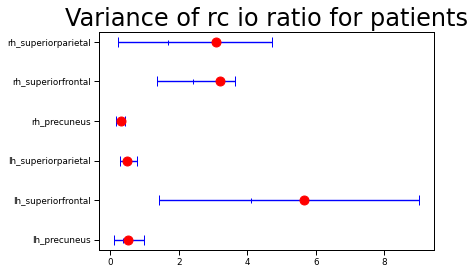

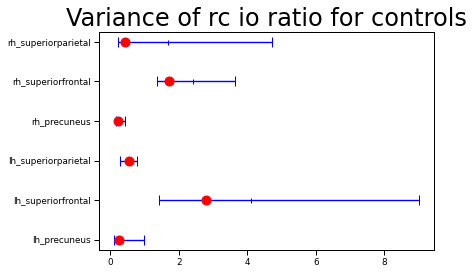

In [40]:
## Examine significance of rc io ratio variance
#sample_groupsize = 'matched'#'all subjects'
statistic_description = 'Variance of rc io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_var_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients[:n_subjects], axis=0),
                         np.var(io_ratio_rc_controls[:n_subjects], axis=0),
                         statistic_description, y_labels)
else:
    examine_var_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients, axis=0),
                         np.var(io_ratio_rc_controls, axis=0),
                         statistic_description, y_labels)

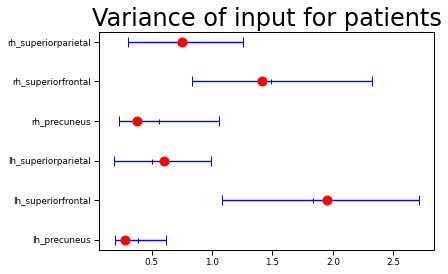

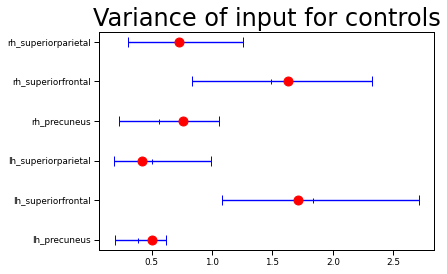

In [41]:
## Examine significance of rc region's input variance
#sample_groupsize = 'matched'#'all subjects'
statistic_description = 'Variance of input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_var_significance(input_rc_patients[:, mask_rc],
                             input_rc_controls[:, mask_rc],
                             np.var(input_rc_patients[:n_subjects, mask_rc], axis=0),
                             np.var(input_rc_controls[:n_subjects, mask_rc], axis=0),
                             statistic_description, y_labels)
else:
    examine_var_significance(input_rc_patients[:, mask_rc],
                             input_rc_controls[:, mask_rc],
                             np.var(input_rc_patients, axis=0),
                             np.var(input_rc_controls, axis=0),
                             statistic_description, y_labels)

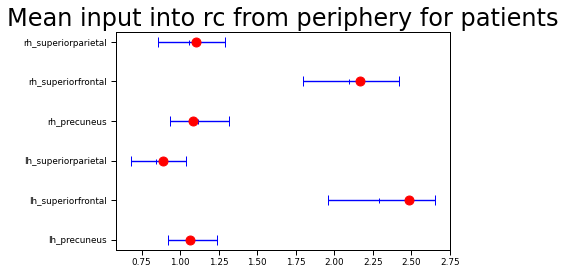

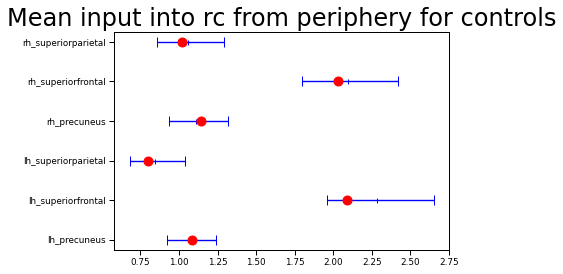

In [42]:
## Examine significance of mean rc input
#sample_groupsize = 'matched'#'all subjects'
statistic_description = 'Mean input into rc from periphery'
y_labels = roi_labels[indexes_rc]
input_rc_patients = input_rc_patients[:, mask_rc]
input_rc_controls = input_rc_controls[:, mask_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_mean_significance(input_rc_patients[:n_subjects],
                              input_rc_controls[:n_subjects],
                              input_rc_patients[:n_subjects].mean(axis=0),
                              input_rc_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels)
else:
    examine_mean_significance(input_rc_patients, input_rc_controls,
                              input_rc_patients.mean(axis=0),
                              input_rc_controls.mean(axis=0),
                              statistic_description, y_labels)

In [43]:
## Examine input and output to and from RC regions.
def calculate_RC_rois_total_input_and_output(
    C, input_is_rowsum=input_is_rowsum_flag):
    """This function is based on calculate_feeder_input_and_output().
    
    """

    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    if io_based_on_nodal_degree_flag:
        input_rois = np.squeeze(
            np.count_nonzero(C, axis=input_axis, keepdims=True))
        output_rois = np.squeeze(
            np.count_nonzero(C, axis=output_axis, keepdims=True))
    else:
        input_rois = C[:, :].sum(axis=input_axis)
        output_rois = C[:, :].sum(axis=output_axis)
    return input_rois, output_rois

RC-indexes:
 [23 26 27 57 60 61]
Investigate input and output regionwise for all connections:


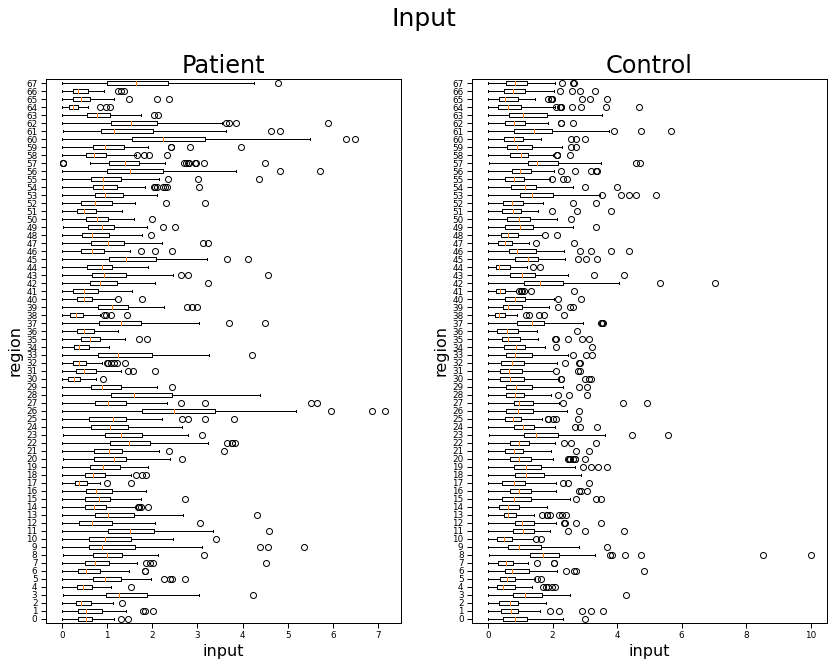

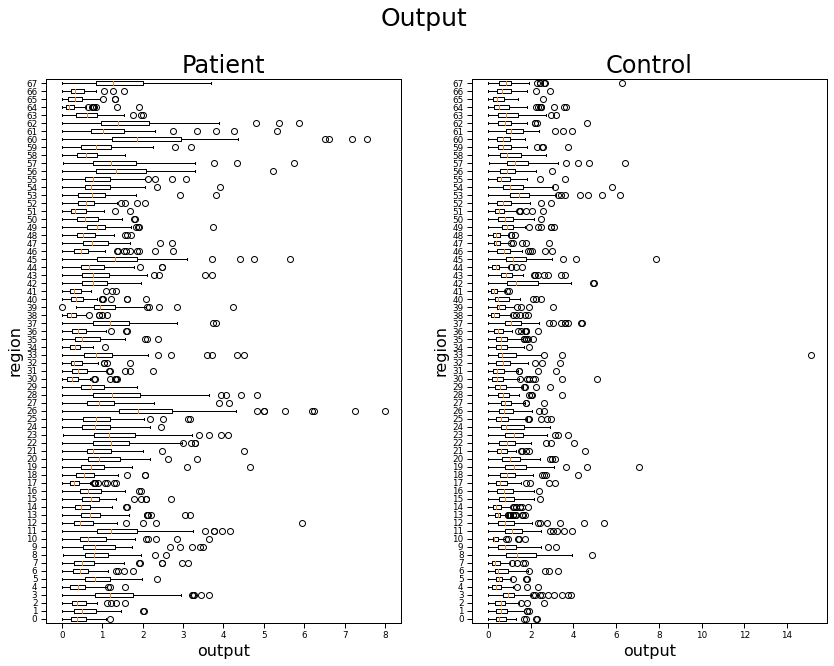

Mean input:	 1.0044752612765353 (patients)	 0.8809067140416044 (contols)


In [44]:
def plot_all_io_group_comparing_boxplot(input_patients, output_patients,
                              input_controls, output_controls):
    plt.figure(figsize=(14, 10))
    plt.suptitle('Input', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    plt.subplot(121)
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    n_rois = input_patients.shape[1]
    plt.boxplot(input_patients, positions = np.arange(n_rois), vert=False)
    plt.subplot(122)
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    n_rois = input_controls.shape[1]
    plt.boxplot(input_controls, positions = np.arange(n_rois), vert=False)
    plt.show()
    plt.figure(figsize=(14, 10))
    plt.suptitle('Output', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    plt.subplot(121)
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    n_rois = output_patients.shape[1]
    plt.boxplot(output_patients, positions = np.arange(n_rois), vert=False)
    plt.subplot(122)
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    n_rois = output_controls.shape[1]
    plt.boxplot(output_controls, positions = np.arange(n_rois), vert=False)
    plt.show()

#print(black('\nPatient group:', 'bold'))
[input_rois_patients, output_rois_patients] = np.squeeze(np.split(
    np.array([ calculate_RC_rois_total_input_and_output(x) for x in C_patients ]),
    2, axis=1))
#print(black('\nControl group:', 'bold'))
[input_rois_controls, output_rois_controls] = np.squeeze(np.split(
    np.array([ calculate_RC_rois_total_input_and_output(x) for x in C_controls ]),
    2, axis=1))
    
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for all connections:',
          'bold'))
plot_all_io_group_comparing_boxplot(
    input_rois_patients,input_rois_controls,
    output_rois_patients, output_rois_controls)
print('Mean input:\t', input_rois_patients.mean(),
  '(patients)\t', input_rois_controls.mean(), '(contols)')

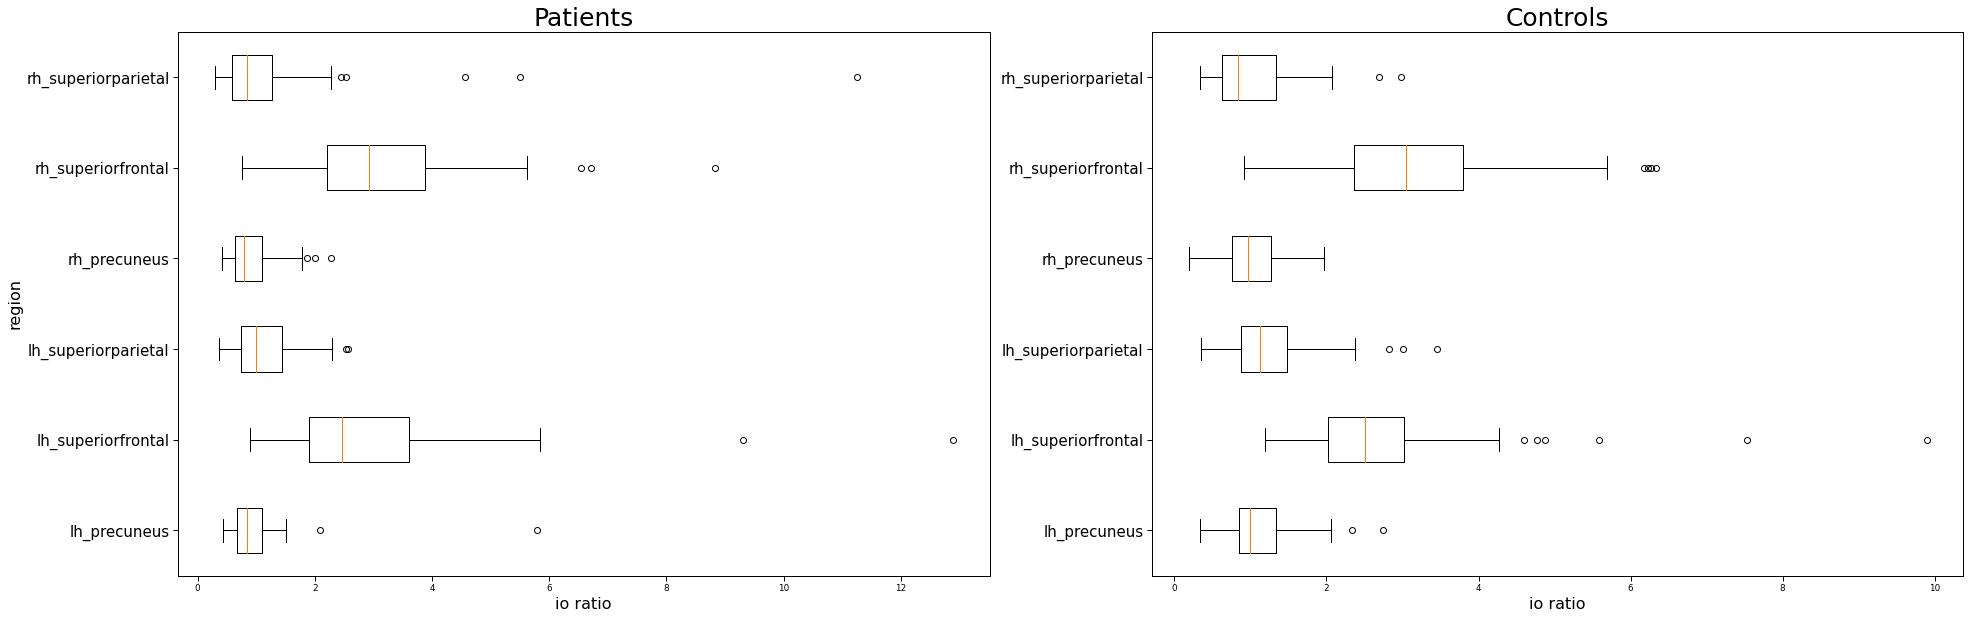

Mean rc io ratio:	 1.7504145168646517 (patients)	 1.7419072369816218 (contols)


In [45]:
## Investigate io ratio of rc regions.
io_ratio_rc_patients = (input_rois_patients[:, mask_rc]
                        / output_rois_patients[:, mask_rc])
io_ratio_rc_controls = (input_rois_controls[:, mask_rc]
                        / output_rois_controls[:, mask_rc])
plot_rc_io_ratio(io_ratio_rc_patients, io_ratio_rc_controls)

io_ratio_rc_mean_patients = io_ratio_rc_patients.mean()
io_ratio_rc_mean_controls = io_ratio_rc_controls.mean()
print('Mean rc io ratio:\t', io_ratio_rc_mean_patients,
      '(patients)\t', io_ratio_rc_mean_controls, '(contols)')

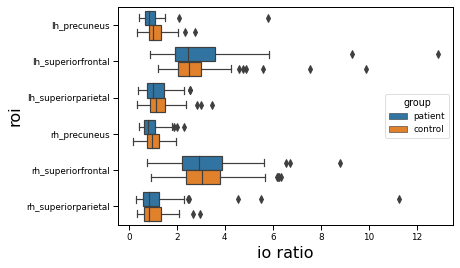

The patient`s variance is greater than the control`s for 5 of 6 rc regions.


In [46]:
## Compare groups in one boxplot with respect to io ratio of rc regions. 
dataframe_patients = pd.DataFrame(io_ratio_rc_patients.reshape(-1),
                                  columns=['io ratio'])
dataframe_patients['group'] = np.repeat('patient', dataframe_patients.size)
dataframe_patients['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_patients, 1).reshape(-1)

dataframe_controls = pd.DataFrame(io_ratio_rc_controls.reshape(-1),
                                  columns=['io ratio'])
dataframe_controls['group'] = np.repeat('control', dataframe_controls.size)
dataframe_controls['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_controls, 1).reshape(-1)

dataframe_all_subjects = dataframe_patients.append(dataframe_controls)

ax = sns.boxplot(x = dataframe_all_subjects['io ratio'], 
            y = dataframe_all_subjects['roi'], 
            hue = dataframe_all_subjects['group'])
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":16})
#ax.set_title("Title",fontsize=24)
plt.show()
roi_count_patients_greater_than_controls = sum(
    np.var(io_ratio_rc_patients, axis=0) > np.var(io_ratio_rc_controls, axis=0))
print('The patient`s variance is greater than the control`s for', 
      roi_count_patients_greater_than_controls, 'of', 
      len(indexes_rc), 'rc regions.')

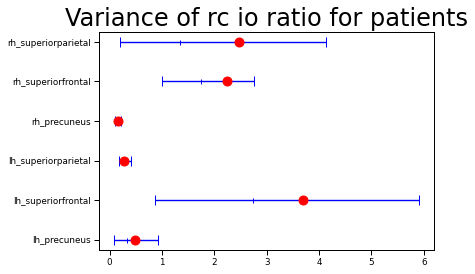

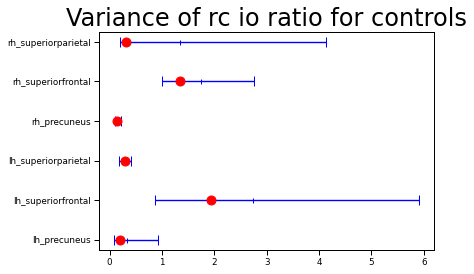

In [47]:
## Examine significance of rc region's io ratio variance
#sample_groupsize = 'matched'#'all subjects'
statistic_description = 'Variance of rc io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_var_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients[:n_subjects], axis=0),
                         np.var(io_ratio_rc_controls[:n_subjects], axis=0),
                         statistic_description, y_labels)
else:
    examine_var_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients, axis=0),
                         np.var(io_ratio_rc_controls, axis=0),
                         statistic_description, y_labels)

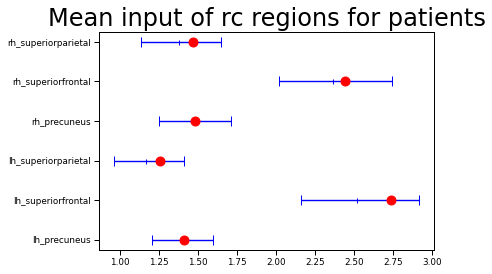

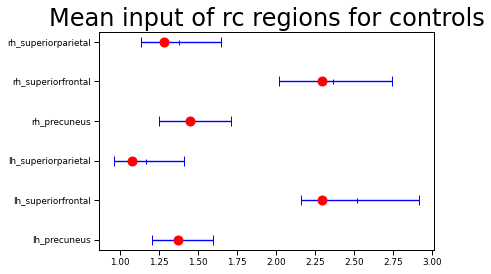

In [48]:
## Examine significance of rc region's io ratio variance
#sample_groupsize = 'matched'#'all subjects'
statistic_description = 'Mean input of rc regions'
y_labels = roi_labels[indexes_rc]
input_rc_patients = input_rois_patients[:, indexes_rc]
input_rc_controls = input_rois_controls[:, indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_mean_significance(input_rc_patients[:n_subjects],
                              input_rc_controls[:n_subjects],
                              input_rc_patients[:n_subjects].mean(axis=0),
                              input_rc_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels)
else:
    examine_mean_significance(input_rc_patients, input_rc_controls,
                              input_rc_patients.mean(axis=0),
                              input_rc_controls.mean(axis=0),
                              statistic_description, y_labels)

In [49]:
## Examine input and output to and from RC regions.
def calculate_long_rc_connections_input_and_output(
    C, input_is_rowsum=input_is_rowsum_flag):
    """This function is based on calculate_feeder_input_and_output().
    
    """

    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    # Create a 2D-mask for inter rich club connections.
    mask_long_rc_connections = np.zeros([n_rois, n_rois], dtype=bool)
    ind_combin_long_rc_connections= np.array(list(
        itertools.product(indexes_rc, repeat=2))).T
    mask_long_rc_connections[ind_combin_long_rc_connections[0],
                          ind_combin_long_rc_connections[1]] = True
    # Set short inter-hemispheric connections to zero.
    for i in range(int(n_rois/2)):
        mask_long_rc_connections[i, int(n_rois/2)+i] = False
        mask_long_rc_connections[int(n_rois/2)+i, i] = False

    long_rc_connections_C = np.copy(C)
    long_rc_connections_C[~mask_long_rc_connections] = 0
    if io_based_on_nodal_degree_flag:
        input_long_rc_connections= np.squeeze(np.count_nonzero(
            long_rc_connections_C, axis=input_axis, keepdims=True))
        output_long_rc_connections= np.squeeze(np.count_nonzero(
            long_rc_connections_C, axis=output_axis, keepdims=True))
    else:
        input_long_rc_connections= long_rc_connections_C[
            :, :].sum(axis=input_axis)
        output_long_rc_connections= long_rc_connections_C[
            :, :].sum(axis=output_axis)
    return input_long_rc_connections, output_long_rc_connections

RC-indexes:
 [23 26 27 57 60 61]
Investigate input and output regionwise for all connections:


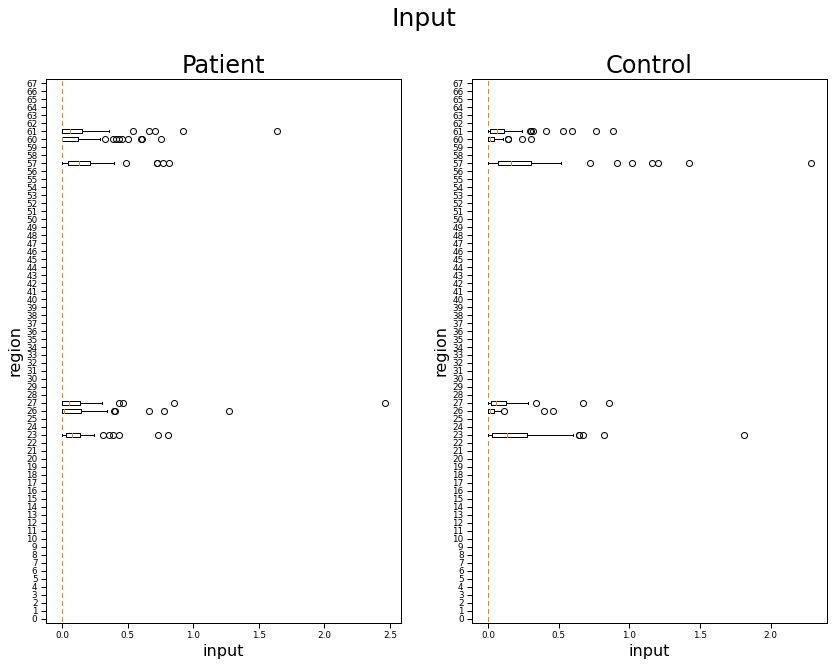

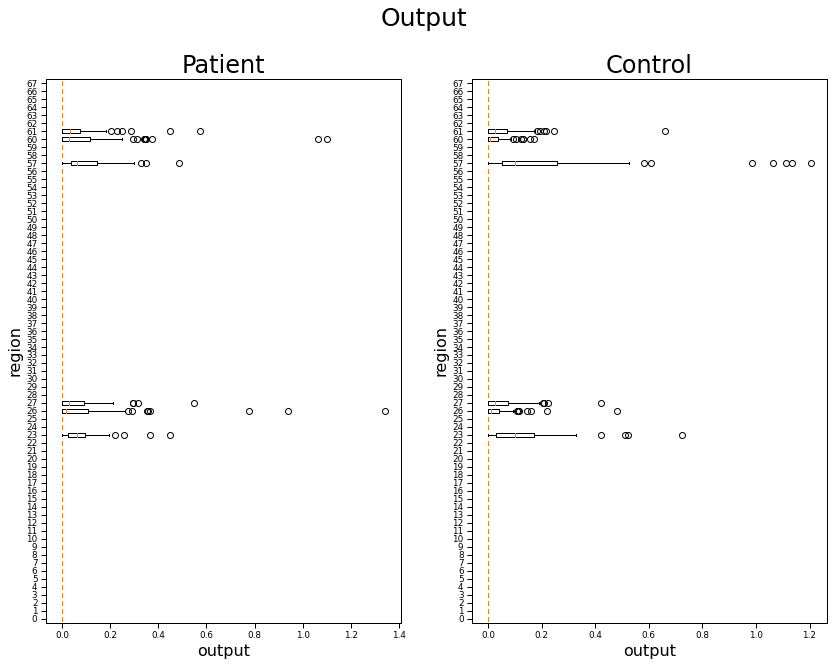

Mean input:	 0.13362989260746155 (patients)	 0.08746548795334445 (contols)


In [50]:
def plot_long_rc_connections_io_boxplot(input_patients, output_patients,
                              input_controls, output_controls):
    plt.figure(figsize=(14, 10))
    plt.suptitle('Input', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    plt.subplot(121)
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    n_rois = input_patients.shape[1]
    plt.boxplot(input_patients, positions = np.arange(n_rois), vert=False)
    plt.subplot(122)
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    n_rois = input_controls.shape[1]
    plt.boxplot(input_controls, positions = np.arange(n_rois), vert=False)
    plt.show()
    plt.figure(figsize=(14, 10))
    plt.suptitle('Output', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    plt.subplot(121)
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    n_rois = output_patients.shape[1]
    plt.boxplot(output_patients, positions = np.arange(n_rois), vert=False)
    plt.subplot(122)
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    n_rois = output_controls.shape[1]
    plt.boxplot(output_controls, positions = np.arange(n_rois), vert=False)
    plt.show()

#print(black('\nPatient group:', 'bold'))
[input_long_con_patients, output_long_con_patients] = \
np.squeeze(np.split(np.array(
    [calculate_long_rc_connections_input_and_output(x) for x in C_patients]),
    2, axis=1))
#print(black('\nControl group:', 'bold'))
[input_long_con_controls, output_long_con_controls] = \
np.squeeze(np.split(np.array([
    calculate_long_rc_connections_input_and_output(x) for x in C_controls]),
    2, axis=1))
    
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for all connections:',
          'bold'))
plot_all_io_group_comparing_boxplot(
    input_long_con_patients, input_long_con_controls,
    output_long_con_patients, output_long_con_controls)
print('Mean input:\t', input_long_con_patients[:, mask_rc].mean(),
  '(patients)\t', input_long_con_controls[:, mask_rc].mean(), '(contols)')

<ipython-input-51-c9f14dfed7f0>:2: RuntimeWarning: divide by zero encountered in true_divide
  io_ratio_long_con_patients = (input_long_con_patients[:, mask_rc]
<ipython-input-51-c9f14dfed7f0>:2: RuntimeWarning: invalid value encountered in true_divide
  io_ratio_long_con_patients = (input_long_con_patients[:, mask_rc]
<ipython-input-51-c9f14dfed7f0>:4: RuntimeWarning: divide by zero encountered in true_divide
  io_ratio_long_con_controls = (input_long_con_controls[:, mask_rc]
<ipython-input-51-c9f14dfed7f0>:4: RuntimeWarning: invalid value encountered in true_divide
  io_ratio_long_con_controls = (input_long_con_controls[:, mask_rc]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


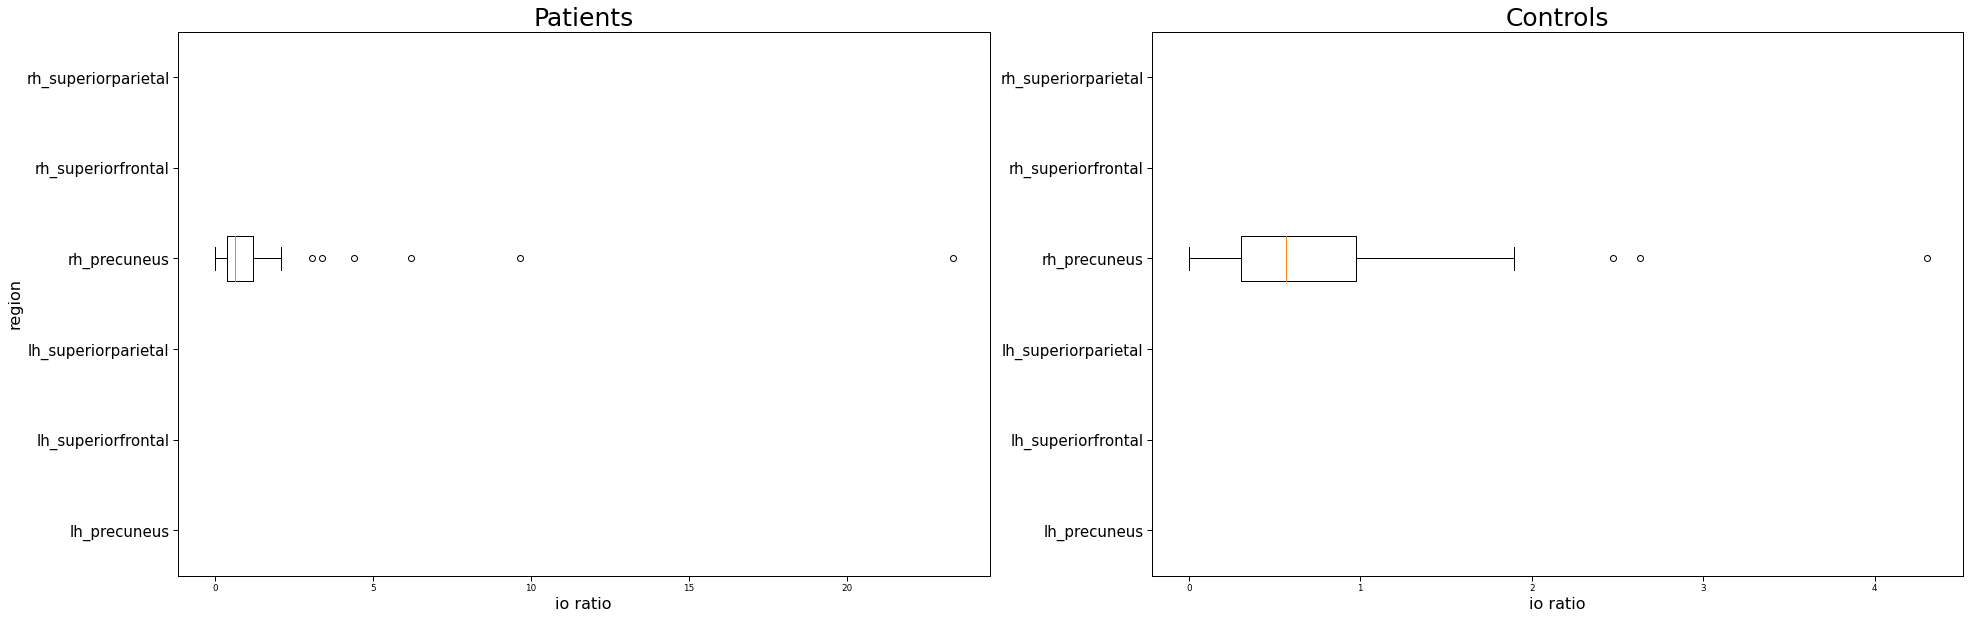

Mean long rc connections io ratio:	 [0.55118039 3.29265698 1.31819351 0.59635007 3.12358954 1.21227696] (patients)	 [0.61989634 3.04047459 1.17727185 0.46189158 3.81441225 1.07986585] (contols)


In [51]:
## Investigate io ratio of long rc connections.
io_ratio_long_con_patients = (input_long_con_patients[:, mask_rc]
                        / output_long_con_patients[:, mask_rc])
io_ratio_long_con_controls = (input_long_con_controls[:, mask_rc]
                        / output_long_con_controls[:, mask_rc])
plot_rc_io_ratio(io_ratio_long_con_patients, io_ratio_long_con_controls)

io_ratio_long_con_mean_patients = (input_long_con_patients[:, mask_rc].mean(axis=0)
                                   / output_long_con_patients[:, mask_rc].mean(axis=0))
io_ratio_long_con_mean_controls = (input_long_con_controls[:, mask_rc].mean(axis=0)
                                   / output_long_con_controls[:, mask_rc].mean(axis=0))
print('Mean long rc connections io ratio:\t', io_ratio_long_con_mean_patients,
      '(patients)\t', io_ratio_long_con_mean_controls, '(contols)')

In [52]:
print(input_long_con_patients[:, mask_rc].mean(axis=0))
print(input_long_con_controls[:, mask_rc].mean(axis=0))

[0.1185588  0.12063014 0.13593162 0.17487632 0.1070124  0.14477007]
[0.07649833 0.11076699 0.06524404 0.1026504  0.10512339 0.06450977]


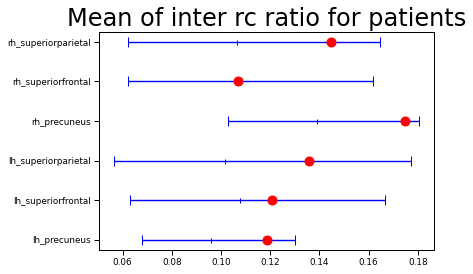

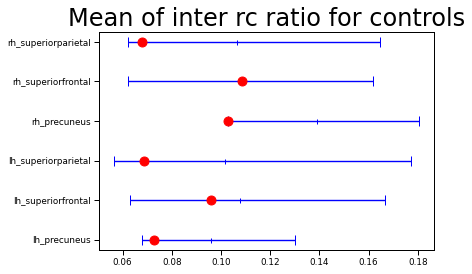

In [53]:
## Examine significance of mean inter rc io ratio
#sample_groupsize = 'matched'#'all subjects'
statistic_description = 'Mean of inter rc ratio'
y_labels = roi_labels[indexes_rc]
input_long_con_patients = input_long_con_patients[:, indexes_rc]
input_long_con_controls = input_long_con_controls[:, indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_mean_significance(input_long_con_patients[:n_subjects],
                              input_long_con_controls[:n_subjects],
                              input_long_con_patients[:n_subjects].mean(axis=0),
                              input_long_con_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels)
else:
    examine_mean_significance(input_long_con_patients, input_long_con_controls,
                              input_long_con_patients.mean(axis=0),
                              input_long_con_controls.mean(axis=0),
                              statistic_description, y_labels)